# Setup / Imports

In [1]:
!pip install dtaidistance

In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
from scipy import signal
#import wave, math
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as shc
from sklearn.metrics.pairwise import pairwise_distances
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from tabulate import tabulate
from termcolor import colored
from IPython.display import display, HTML
import math
from scipy.spatial.distance import squareform
from dtaidistance import dtw
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage
import time
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [3]:
# granger imports
from __future__ import annotations

from statsmodels.compat.numpy import lstsq
from statsmodels.compat.pandas import deprecate_kwarg
# from statsmodels.compat.python import Literal, lzip
from statsmodels.compat.scipy import _next_regular

from typing import Union, List
import warnings

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
from scipy.signal import correlate

from statsmodels.regression.linear_model import OLS, yule_walker
from statsmodels.tools.sm_exceptions import (
    CollinearityWarning,
    InfeasibleTestError,
    InterpolationWarning,
    MissingDataError,
    ValueWarning,
)
from statsmodels.tools.tools import Bunch, add_constant
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    dict_like,
    float_like,
    int_like,
    string_like,
)
from statsmodels.tsa._bds import bds
from statsmodels.tsa._innovations import innovations_algo, innovations_filter
from statsmodels.tsa.adfvalues import mackinnoncrit, mackinnonp
from statsmodels.tsa.tsatools import add_trend, lagmat, lagmat2ds

In [4]:
# If using Google drive / colab
# from google.colab import drive
# drive.mount("/content/gdrive")

# define your base_dir for the data and figures
base_dir = "Synthetic Data Figures and Data/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Setup Causal Timeseries

In [5]:
ts_len = 1000 # Length of time series
causal_timeseries = []
cluster_size = 4 # Number of Alpha TS per cluster
output_num = 3 # Number of beta TS per cluster
num_clusters = 6 # Number of clusters
causal_timeseries = np.load(base_dir + "causal_timeseries.npy")

### Setup functions to generate effect timeseries and run granger

In [6]:
def grangercausalitytests_custom(x, maxlag, addconst=True, verbose=None):
    """
    Four tests for granger non causality of 2 time series.

    All four tests give similar results. `params_ftest` and `ssr_ftest` are
    equivalent based on F test which is identical to lmtest:grangertest in R.

    Parameters
    ----------
    x : array_like
        The data for testing whether the time series in the second column Granger
        causes the time series in the first column. Missing values are not
        supported.
    maxlag : {int, Iterable[int]}
        If an integer, computes the test for all lags up to maxlag. If an
        iterable, computes the tests only for the lags in maxlag.
    addconst : bool
        Include a constant in the model.
    verbose : bool
        Print results. Deprecated

        .. deprecated: 0.14

           verbose is deprecated and will be removed after 0.15 is released



    Returns
    -------
    dict
        All test results, dictionary keys are the number of lags. For each
        lag the values are a tuple, with the first element a dictionary with
        test statistic, pvalues, degrees of freedom, the second element are
        the OLS estimation results for the restricted model, the unrestricted
        model and the restriction (contrast) matrix for the parameter f_test.

    Notes
    -----
    TODO: convert to class and attach results properly

    The Null hypothesis for grangercausalitytests is that the time series in
    the second column, x2, does NOT Granger cause the time series in the first
    column, x1. Grange causality means that past values of x2 have a
    statistically significant effect on the current value of x1, taking past
    values of x1 into account as regressors. We reject the null hypothesis
    that x2 does not Granger cause x1 if the pvalues are below a desired size
    of the test.

    The null hypothesis for all four test is that the coefficients
    corresponding to past values of the second time series are zero.

    `params_ftest`, `ssr_ftest` are based on F distribution

    `ssr_chi2test`, `lrtest` are based on chi-square distribution

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Granger_causality

    .. [2] Greene: Econometric Analysis

    Examples
    --------
    >>> import statsmodels.api as sm
    >>> from statsmodels.tsa.stattools import grangercausalitytests
    >>> import numpy as np
    >>> data = sm.datasets.macrodata.load_pandas()
    >>> data = data.data[["realgdp", "realcons"]].pct_change().dropna()

    All lags up to 4

    >>> gc_res = grangercausalitytests(data, 4)

    Only lag 4

    >>> gc_res = grangercausalitytests(data, [4])
    """
    x = array_like(x, "x", ndim=2)
    if not np.isfinite(x).all():
        raise ValueError("x contains NaN or inf values.")
    addconst = bool_like(addconst, "addconst")
    if verbose is not None:
        verbose = bool_like(verbose, "verbose")
        warnings.warn(
            "verbose is deprecated since functions should not print results",
            FutureWarning,
        )
    else:
        verbose = True  # old default

    try:
        maxlag = int_like(maxlag, "maxlag")
        if maxlag <= 0:
            raise ValueError("maxlag must be a positive integer")
        lags = np.arange(1, maxlag + 1)
    except TypeError:
        lags = np.array([int(lag) for lag in maxlag])
        maxlag = lags.max()
        if lags.min() <= 0 or lags.size == 0:
            raise ValueError(
                "maxlag must be a non-empty list containing only "
                "positive integers"
            )

    if x.shape[0] <= 3 * maxlag + int(addconst):
        raise ValueError(
            "Insufficient observations. Maximum allowable "
            "lag is {}".format(int((x.shape[0] - int(addconst)) / 3) - 1)
        )

    resli = {}

    for mlg in lags:
        result = {}
        if verbose:
            print("\nGranger Causality")
            print("number of lags (no zero)", mlg)
        mxlg = mlg

        # create lagmat of both time series
        dta = lagmat2ds(x, mxlg, trim="both", dropex=1)

        # add constant
        if addconst:
            dtaown = add_constant(dta[:, 1 : (mxlg + 1)], prepend=False)
            dtajoint = add_constant(dta[:, 1:], prepend=False)
            if (
                dtajoint.shape[1] == (dta.shape[1] - 1)
                or (dtajoint.max(0) == dtajoint.min(0)).sum() != 1
            ):
                raise InfeasibleTestError(
                    "The x values include a column with constant values and so"
                    " the test statistic cannot be computed."
                )
        else:
            raise NotImplementedError("Not Implemented")
            # dtaown = dta[:, 1:mxlg]
            # dtajoint = dta[:, 1:]

        # Run ols on both models without and with lags of second variable
        res2down = OLS(dta[:, 0], dtaown).fit()
        res2djoint = OLS(dta[:, 0], dtajoint).fit()

        # print results
        # for ssr based tests see:
        # http://support.sas.com/rnd/app/examples/ets/granger/index.htm
        # the other tests are made-up

        # Granger Causality test using ssr (F statistic)
        if res2djoint.model.k_constant:
            tss = res2djoint.centered_tss
        else:
            tss = res2djoint.uncentered_tss
        if (
            tss == 0
            or res2djoint.ssr == 0
            or np.isnan(res2djoint.rsquared)
            or (res2djoint.ssr / tss) < np.finfo(float).eps
            or res2djoint.params.shape[0] != dtajoint.shape[1]
        ):
            raise InfeasibleTestError(
                "The Granger causality test statistic cannot be compute "
                "because the VAR has a perfect fit of the data."
            )
        fgc1 = (
            (res2down.ssr - res2djoint.ssr)
            / res2djoint.ssr
            / mxlg
            * res2djoint.df_resid
        )
        if verbose:
            print(
                "ssr based F test:         F=%-8.4f, p=%-8.4f, df_denom=%d,"
                " df_num=%d"
                % (
                    fgc1,
                    stats.f.sf(fgc1, mxlg, res2djoint.df_resid),
                    res2djoint.df_resid,
                    mxlg,
                )
            )
        result["ssr_ftest"] = (
            fgc1,
            stats.f.sf(fgc1, mxlg, res2djoint.df_resid),
            res2djoint.df_resid,
            mxlg,
        )

        # Granger Causality test using ssr (ch2 statistic)
        fgc2 = res2down.nobs * (res2down.ssr - res2djoint.ssr) / res2djoint.ssr
        if verbose:
            print(
                "ssr based chi2 test:   chi2=%-8.4f, p=%-8.4f, "
                "df=%d" % (fgc2, stats.chi2.sf(fgc2, mxlg), mxlg)
            )
        result["ssr_chi2test"] = (fgc2, stats.chi2.sf(fgc2, mxlg), mxlg)

        # likelihood ratio test pvalue:
        lr = -2 * (res2down.llf - res2djoint.llf)
        if verbose:
            print(
                "likelihood ratio test: chi2=%-8.4f, p=%-8.4f, df=%d"
                % (lr, stats.chi2.sf(lr, mxlg), mxlg)
            )
        result["lrtest"] = (lr, stats.chi2.sf(lr, mxlg), mxlg)

        # F test that all lag coefficients of exog are zero
        rconstr = np.column_stack(
            (np.zeros((mxlg, mxlg)), np.eye(mxlg, mxlg), np.zeros((mxlg, 1)))
        )
        ftres = res2djoint.f_test(rconstr)
        if verbose:
            print(
                "parameter F test:         F=%-8.4f, p=%-8.4f, df_denom=%d,"
                " df_num=%d"
                % (ftres.fvalue, ftres.pvalue, ftres.df_denom, ftres.df_num)
            )
        result["params_ftest"] = (
            np.squeeze(ftres.fvalue)[()],
            np.squeeze(ftres.pvalue)[()],
            ftres.df_denom,
            ftres.df_num,
        )

        result["aic"] = res2djoint.aic
        result["bic"] = res2djoint.bic
        hq = - 2 * res2djoint.llf + 2 * mxlg * np.log(np.log(res2djoint.nobs))
        result["hq"] = hq
        result["llf_unrestricted"] = res2djoint.llf
        result["llf_restricted"] = res2down.llf
        result["ssr_restricted"] = res2down.ssr
        result["ssr_unrestricted "]= res2djoint.ssr
        result["nobs"] = res2djoint.nobs

        # print(res2djoint.summary())
        # if (mxlg == 21):
        #     return res2djoint

        resli[mxlg] = (result, [-1]) #res2down, res2djoint, rconstr

    return resli


In [7]:
def generate_effect(causal_timeseries, w, n):
    effect_timeseries = []
    lags = []
    for c in range(num_clusters):
        ts_cluster = causal_timeseries[c*cluster_size:c*cluster_size+cluster_size]
        for d in range(output_num):
            weights = np.full(cluster_size, w[c]) # make weight matrix
            lag =  np.random.randint(7,21) # generate a lag and save it for comparison later
            lags.append(lag)
            output = np.roll(weights.dot(ts_cluster), lag) # apply weights and shift timeseries
            output = np.sum([output, np.random.normal(0,n[c],ts_len)], axis=0) # take down to 1d and add noise
            effect_timeseries.append(output)

    for x in effect_timeseries:
        if adfuller(x)[1] > 0.5:
            print("Not Stationary")

    return effect_timeseries, lags

def get_granger_matrix(causal_timeseries, effect_timeseries):
    import warnings
    warnings.filterwarnings('ignore')
    granger_results = []
    lags = []
    for cts in causal_timeseries:
        gres = []
        row_lags = []
        for ets in effect_timeseries:
            g_input = np.concatenate([np.vstack(ets), np.vstack(cts)], axis=1)
            results = grangercausalitytests(g_input, maxlag=21, verbose=0)
            p_vals = []
            for lag in results:
                p_vals.append(results[lag][0]['ssr_ftest'][1])
            result = min(p_vals)
            best_lag = np.argmin(p_vals)
            row_lags.append(best_lag)
            gres.append(result)
        granger_results.append(gres)
        lags.append(row_lags)
    return np.array(granger_results), np.array(lags)



def get_granger_matrix_with_aic_bic(causal_timeseries, effect_timeseries):
    import warnings
    warnings.filterwarnings('ignore')
    granger_results_pval = []
    granger_results_aic = []
    granger_results_bic = []
    granger_results_hq = []
    lags_pval = []
    lags_aic = []
    lags_bic = []
    lags_hq = []
    all_results = []
    for cts in causal_timeseries:
        gres_ps = []
        gres_aic = []
        gres_bic = []
        gres_hq = []
        chosen_lag_pval = []
        chosen_lag_aic = []
        chosen_lag_bic = []
        chosen_lag_hq = []
        for ets in effect_timeseries:
            g_input = np.concatenate([np.vstack(ets), np.vstack(cts)], axis=1)
            results = grangercausalitytests_custom(g_input, maxlag=21, verbose=0)
            p_vals = []
            aics = []
            bics = []
            hqs = []
            for i, lag in enumerate(results):
                p_vals.append(results[lag][0]['ssr_ftest'][1])
                aics.append(results[lag][0]['aic'])
                bics.append(results[lag][0]['bic'])
                hqs.append(results[lag][0]['hq'])
            all_results.append(results)

            # min pvalue
            min_pval = min(p_vals)
            min_pval_lag = np.argmin(p_vals) + 1 # + 1 because lag is 1 indexed
            chosen_lag_pval.append(min_pval_lag)
            gres_ps.append(min_pval)

            # min aic
            min_aic_lag = np.argmin(aics) + 1
            min_pval_using_aic = p_vals[np.argmin(aics)]
            chosen_lag_aic.append(min_aic_lag)
            gres_aic.append(min_pval_using_aic)

            # min bic
            min_bic_lag = np.argmin(bics) + 1
            min_pval_using_bic = p_vals[np.argmin(bics)]
            chosen_lag_bic.append(min_bic_lag)
            gres_bic.append(min_pval_using_bic)

            # min hq
            min_hq_lag = np.argmin(hqs) + 1
            min_pval_using_hq = p_vals[np.argmin(hqs)]
            chosen_lag_hq.append(min_hq_lag)
            gres_hq.append(min_pval_using_hq)

            # row_lags.append({"p_vals"})
            # gres.append(result)
        granger_results_pval.append(gres_ps)
        granger_results_aic.append(gres_aic)
        granger_results_bic.append(gres_bic)
        granger_results_hq.append(gres_hq)
        lags_pval.append(chosen_lag_pval)
        lags_aic.append(chosen_lag_aic)
        lags_bic.append(chosen_lag_bic)
        lags_hq.append(chosen_lag_hq)

    return {"granger_results_pval": np.array(granger_results_pval), "granger_results_aic": np.array(granger_results_aic), "granger_results_bic": np.array(granger_results_bic), "granger_results_hq": np.array(granger_results_hq)}, {"lags_pval": np.array(lags_pval), "lags_aic": np.array(lags_aic), "lags_bic": np.array(lags_bic), "lags_hq":np.array(lags_hq), "all_results": all_results}

In [8]:
weights = [[1,1,1,1,1,1],
           [1,1,1,1,1,1],
           [1, 0.84, 0.68, 0.52, 0.36, 0.2],
           [1, 0.84, 0.68, 0.52, 0.36, 0.2]]

noises = [[1,1,1,1,1,1],
          [0.25, 0.5, 0.75, 1, 1.25, 1.5],
          [1,1,1,1,1,1],
          [0.25, 0.5, 0.75, 1, 1.25, 1.5]]

#### Original Code

In [9]:
# effect_timeseries_groups_final = []
# ground_truth_lags = []
# pred_lags = []
# granger_results_groups_final = []
# for i, _ in enumerate(noises):
#     # get effect ts
#     effect_timeseries, gtl = generate_effect(causal_timeseries, weights[i], noises[i])
#     ground_truth_lags.append(gtl)
#     effect_timeseries_groups_final.append(effect_timeseries)

#     # get granger results
#     granger_results, pl = get_granger_matrix(causal_timeseries, effect_timeseries)
#     pred_lags.append(pl)
#     granger_results_groups_final.append(granger_results)

#### Loading saved data code:

In [10]:
effect_timeseries_groups_final = []
effect_ts_file_names = ["effect_ts_constant_weight_constant_noise.npy", "effect_ts_constant_weight_increasing_noise.npy", "effect_ts_decreasing_weight_constant_noise.npy", "effect_ts_decreasing_weight_increasing_noise.npy"]
for name in effect_ts_file_names:
    effect_timeseries_groups_final.append(np.load(base_dir + name))

In [11]:
pred_lags = []
granger_results_groups_final = []
for i, _ in enumerate(noises):
    # get granger results
    granger_results, pl = get_granger_matrix_with_aic_bic(causal_timeseries, effect_timeseries_groups_final[i])
    pred_lags.append(pl)
    granger_results_groups_final.append(granger_results)

In [12]:
# np.save(base_dir + "granger_results_groups_final_sept17_for_correct_logistic_regression.npy", granger_results_groups_final)

In [13]:
# granger_results_groups_final = np.load(base_dir + "granger_results_groups_final_sept17_for_correct_logistic_regression.npy",allow_pickle=True)

# Granger

#### Constant Weight and Constant Noise (Min Pval)

[4 4 4 4 3 3 3 3 6 6 6 6 2 2 2 2 5 5 5 5 1 1 1 1]
Adjusted Rand Index: 1.0
Normalized Mutual Information: 1.0


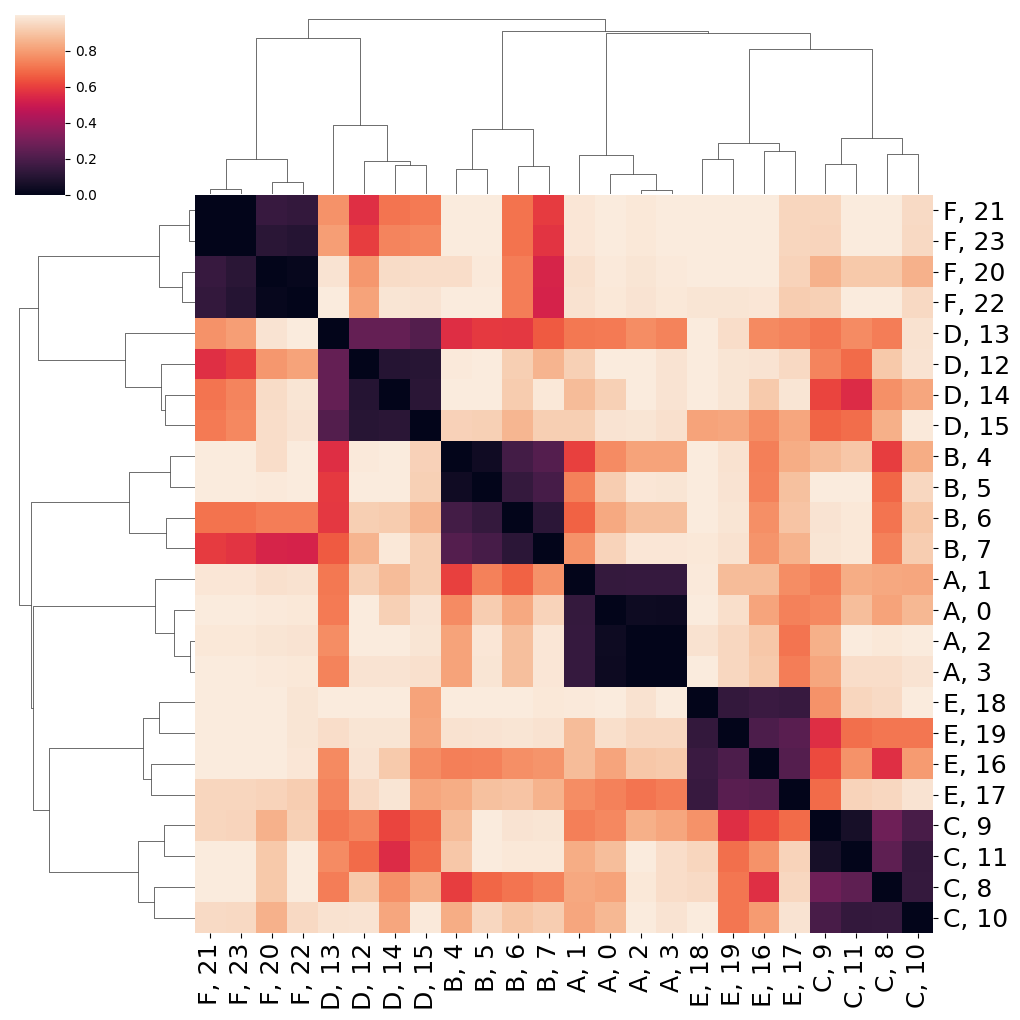

In [14]:
temp = np.array(granger_results_groups_final[0]["granger_results_pval"])
temp_inv = 1-1/(1+np.exp(-100*(temp-0.01)))
temp_xdata = pairwise_distances(temp_inv, metric='cosine')

linkage_matrix = linkage(temp_xdata, method='complete')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(temp_xdata,
                row_linkage=linkage_matrix,
                col_linkage=linkage_matrix,
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)

# np.save(base_dir + "effect_ts_constant_weight_constant_noise.npy", effect_timeseries_groups_final[0]) # commented out now that i've generted it once and loaded it in
# Uncomment to save figure
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "granger_constant_weight_constant_noise_PVAL.png")
# files.download("constant_weight_constant_noise.png")


true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

#### Constant Weight and Increasing Noise

[3 3 3 3 2 2 2 2 4 4 4 4 5 5 5 5 1 1 1 1 6 6 6 6]
Adjusted Rand Index: 1.0
Normalized Mutual Information: 1.0


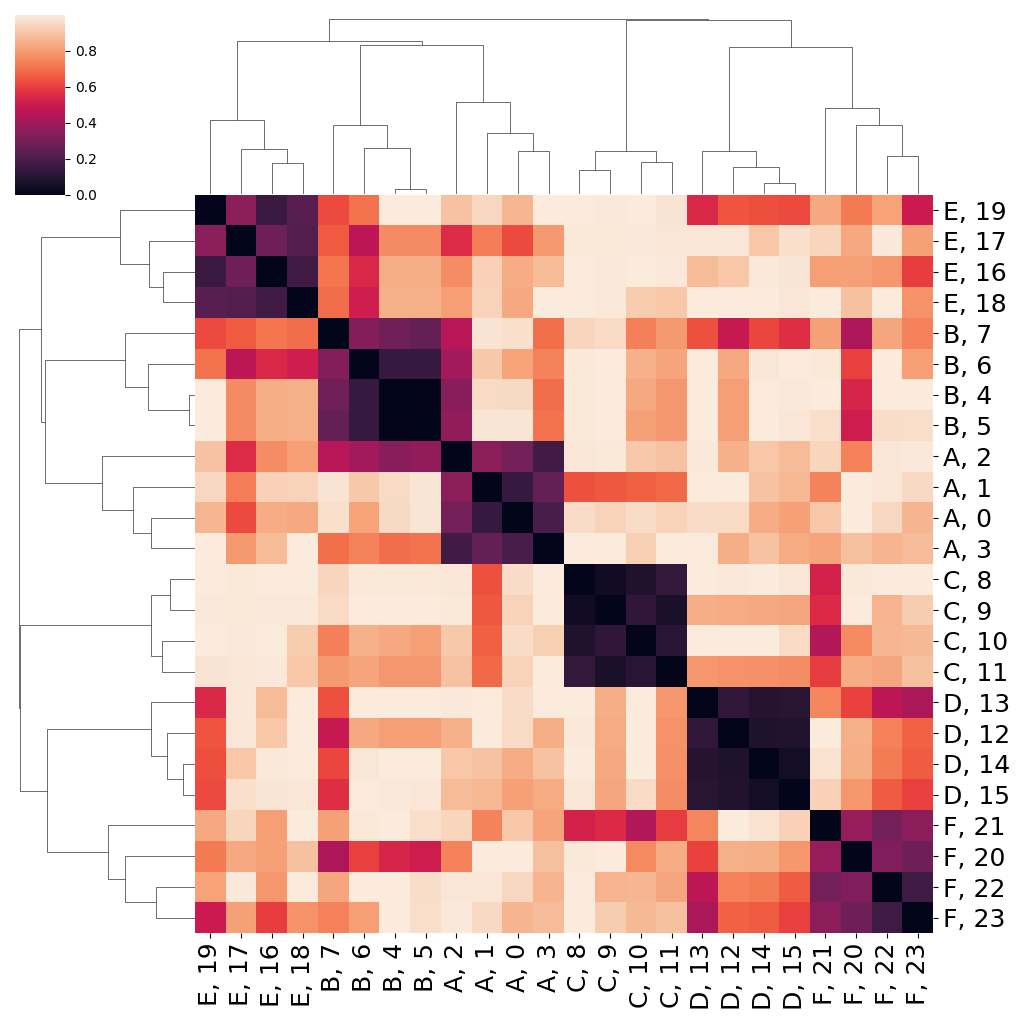

In [15]:
temp = np.array(granger_results_groups_final[1]["granger_results_pval"])
temp_inv = 1-1/(1+np.exp(-100*(temp-0.01)))
temp_xdata = pairwise_distances(temp_inv, metric='cosine')

linkage_matrix = linkage(temp_xdata, method='complete')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(temp_xdata,
                row_linkage=linkage_matrix,
                col_linkage=linkage_matrix,
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
# np.save(base_dir + "effect_ts_constant_weight_increasing_noise.npy", effect_timeseries_groups_final[1]) # commented out now that i've generted it once and loaded it in

# Uncomment to save figure
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "granger_constant_weight_increasing_noise.png")
# files.download("constant_weight_increasing_noise.png")

true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

#### Decreasing Weight and Constant Noise

[3 3 3 3 1 1 1 1 5 5 5 5 6 6 6 6 2 2 2 2 4 2 4 1]
Adjusted Rand Index: 0.7994634473507712
Normalized Mutual Information: 0.892402757184865


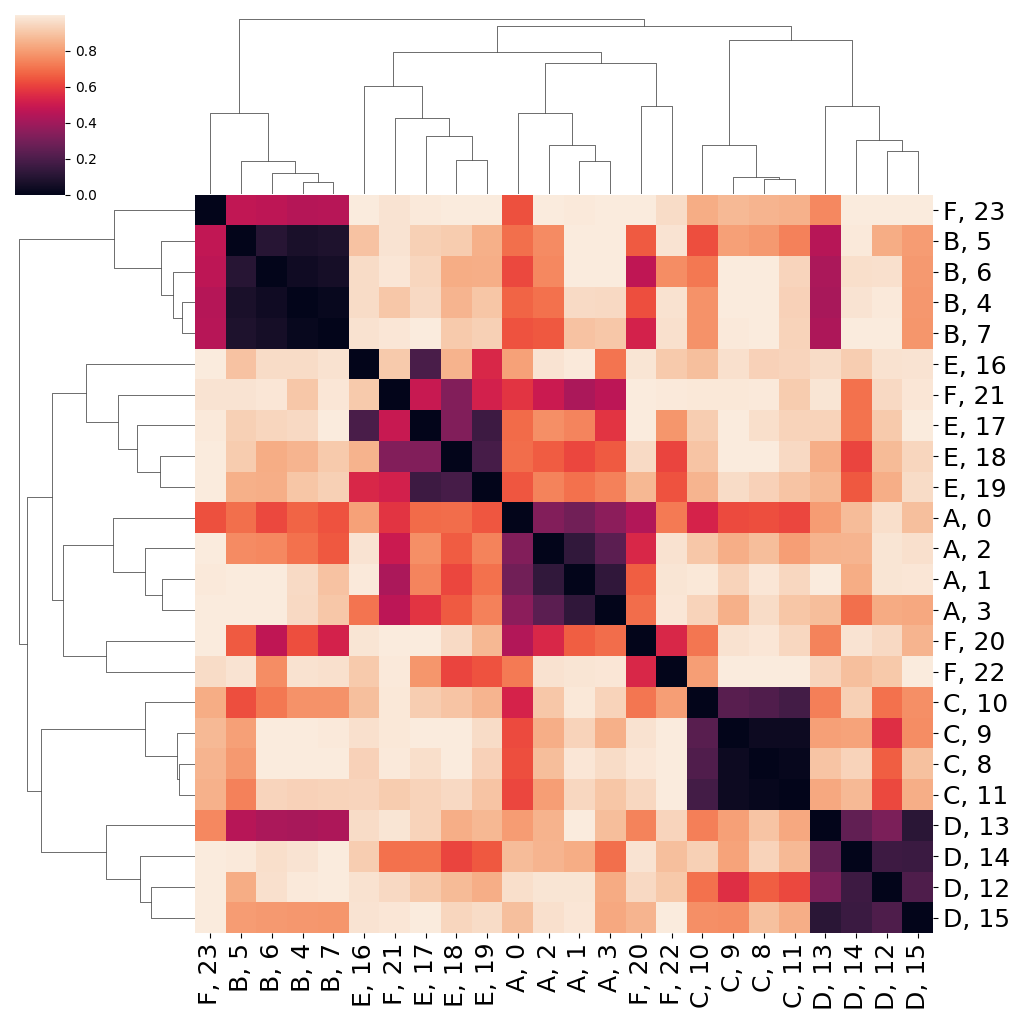

In [16]:
temp = np.array(granger_results_groups_final[2]["granger_results_pval"])
temp_inv = 1-1/(1+np.exp(-100*(temp-0.01)))
temp_xdata = pairwise_distances(temp_inv, metric='cosine')

linkage_matrix = linkage(temp_xdata, method='complete')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(temp_xdata,
                row_linkage=linkage_matrix,
                col_linkage=linkage_matrix,
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)

# np.save(base_dir + "effect_ts_decreasing_weight_constant_noise.npy", effect_timeseries_groups_final[2]) # commented out now that i've generted it once and loaded it in
# Uncomment to save figure
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "granger_decreasing_weight_constant_noise.png")
# files.download("decreasing_weight_constant_noise.png")

true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

#### Decreasing Weight and Increasing Noise

[3 3 3 3 1 1 1 1 2 2 2 2 4 4 4 4 5 5 5 6 5 2 6 3]
Adjusted Rand Index: 0.676056338028169
Normalized Mutual Information: 0.8070184393531896


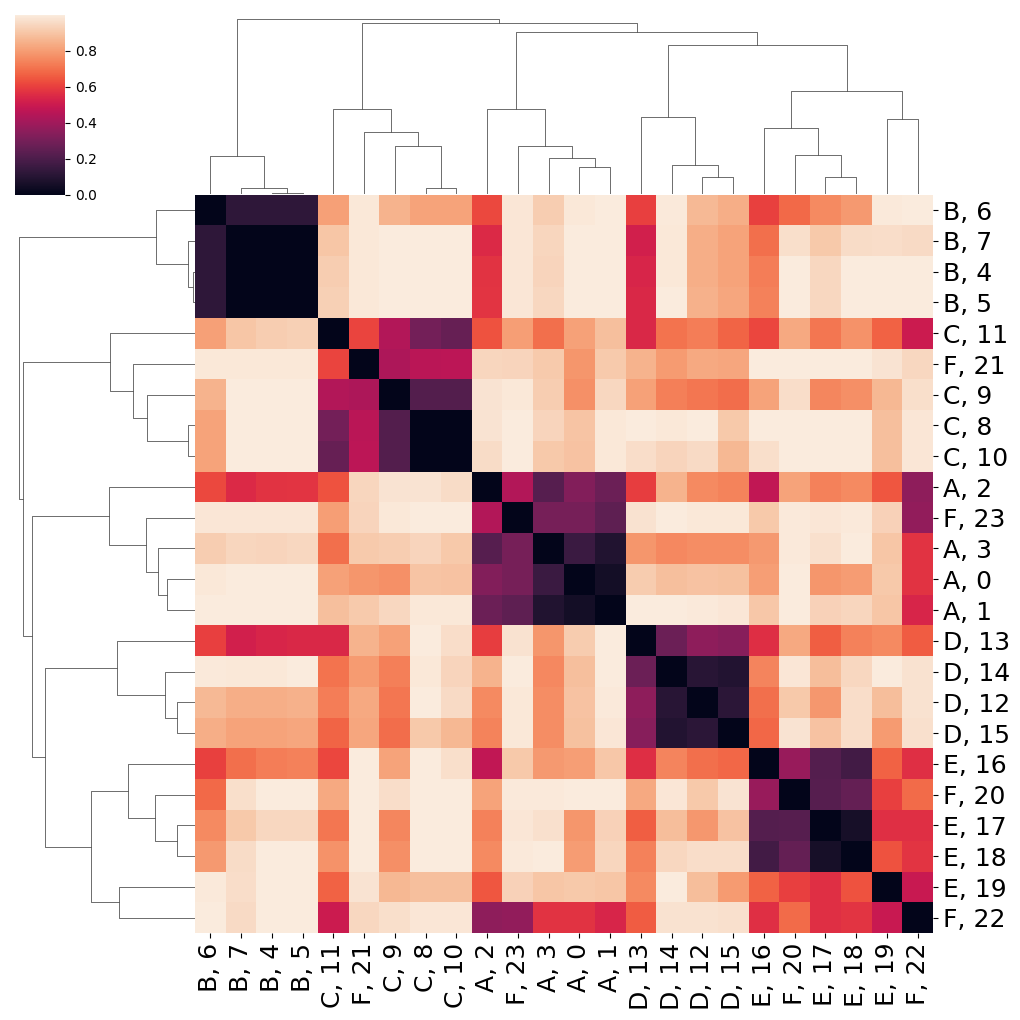

In [17]:
temp = np.array(granger_results_groups_final[3]["granger_results_pval"])
temp_inv = 1-1/(1+np.exp(-100*(temp-0.01)))
temp_xdata = pairwise_distances(temp_inv, metric='cosine')

linkage_matrix = linkage(temp_xdata, method='complete')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(temp_xdata,
                row_linkage=linkage_matrix,
                col_linkage=linkage_matrix,
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)


# np.save(base_dir + "effect_ts_decreasing_weight_increasing_noise.npy", effect_timeseries_groups_final[3]) # commented out now that i've generted it once and loaded it in
# Uncomment to save figure
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "granger_decreasing_weight_increasing_noise.png")
# files.download("decreasing_weight_increasing_noise.png")

true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

# Pearson Correlation Clustering

#### Just A

In [18]:
def get_pearson_distance_matrix(causal_timeseries, effect_timeseries):
    pearson_results = []
    for c in causal_timeseries:
        one_row_result = []
        for e in effect_timeseries:
            temp_distance = 1 - stats.pearsonr(c, e).statistic
            one_row_result.append(temp_distance)
        pearson_results.append(one_row_result)

    return np.array(pearson_results)

<ipython-input-22-06c6fc312acf>:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(pearson_results_just_A, method='complete')


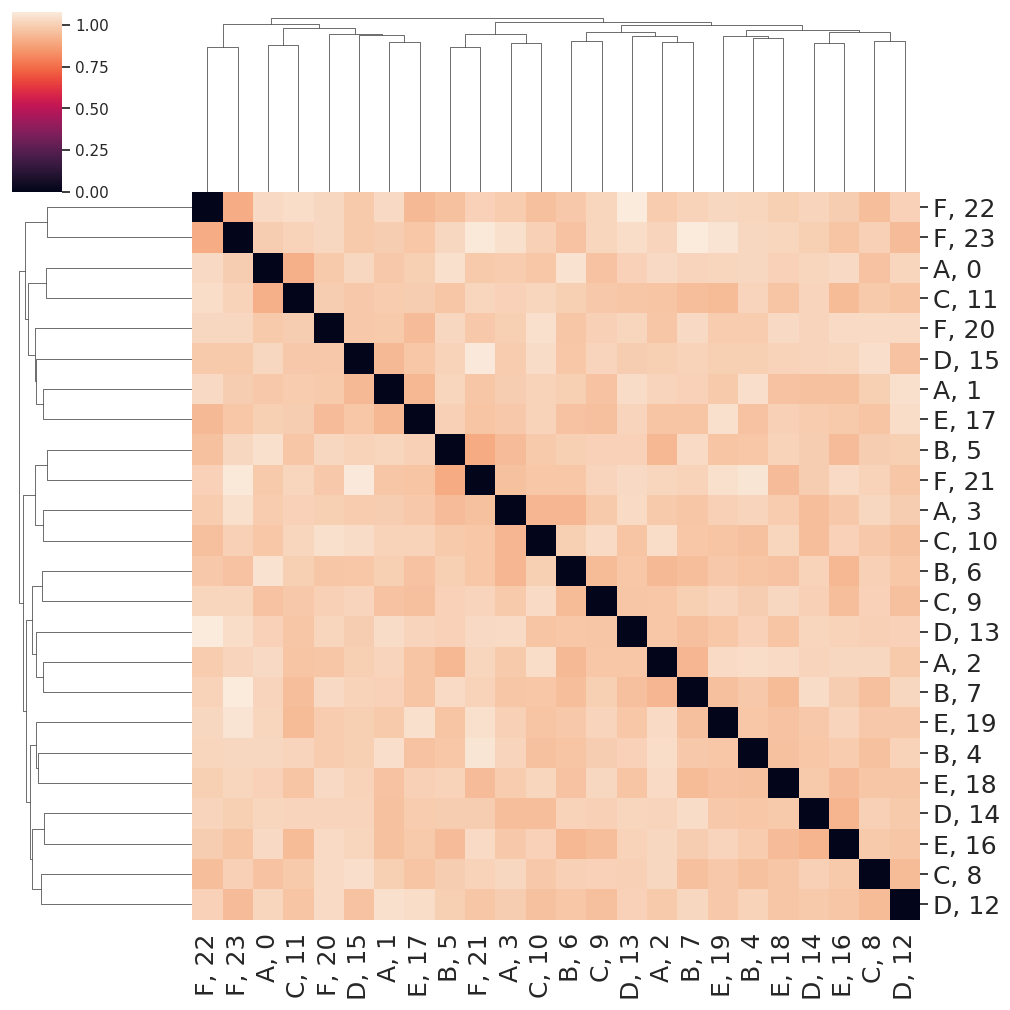

In [ ]:
pearson_results_just_A = get_pearson_distance_matrix(causal_timeseries, causal_timeseries)
# Compute the linkage matrix for clustering
linkage_matrix = linkage(pearson_results_just_A, method='complete')


# Create a clustermap using the DTW distance matrix
sns.set(font_scale=1)
raw_clustermap = sns.clustermap(pearson_results_just_A,
                                row_linkage=linkage_matrix,
                                col_linkage=linkage_matrix,
                                col_cluster=True,
                                cmap='rocket',
                                figsize=(10,10),
                                yticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)],
                                xticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)])
raw_clustermap.ax_heatmap.tick_params(labelsize=18)
plt.setp(raw_clustermap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
raw_clustermap.savefig(base_dir + "pearson_clustering_on_just_causal_ts.png")


In [19]:
pearson_results_groups_final = []
for ets in effect_timeseries_groups_final:
    pearson_results = get_pearson_distance_matrix(causal_timeseries, ets)
    pearson_results_groups_final.append(pearson_results)
    # break

#### Constant Weight and Constant Noise

[4 5 6 3 5 3 3 5 4 5 2 5 5 2 5 5 4 1 3 5 5 3 5 1]
Adjusted Rand Index: -0.048562933597621406
Normalized Mutual Information: 0.2881527828825337


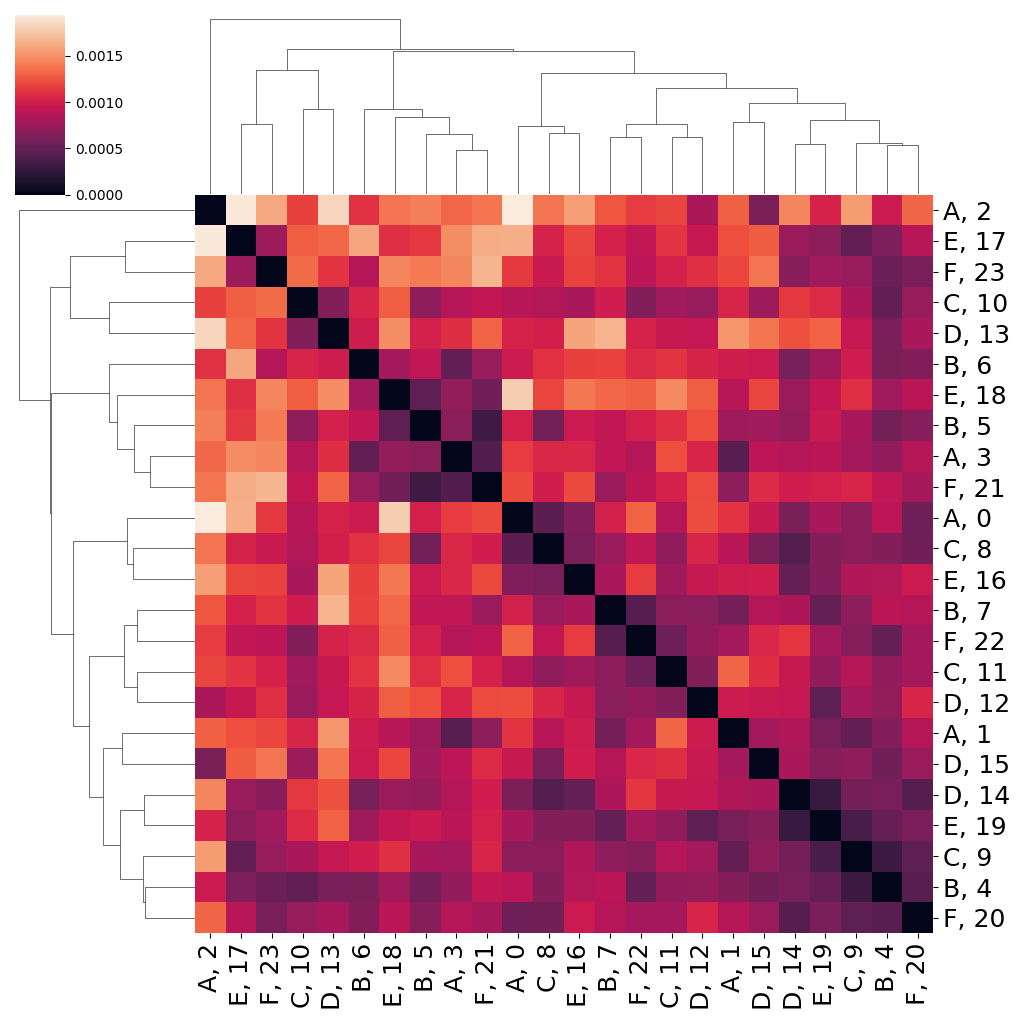

In [20]:
xdata_pearson = pairwise_distances(pearson_results_groups_final[0], metric='cosine')
# Compute the linkage matrix for clustering
linkage_matrix = linkage(xdata_pearson, method='complete')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(xdata_pearson,
                 row_linkage=linkage_matrix,
                       col_linkage=linkage_matrix,
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "pearson_constant_weight_constant_noise.png")

true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

#### Constant Weight and Increasing Noise

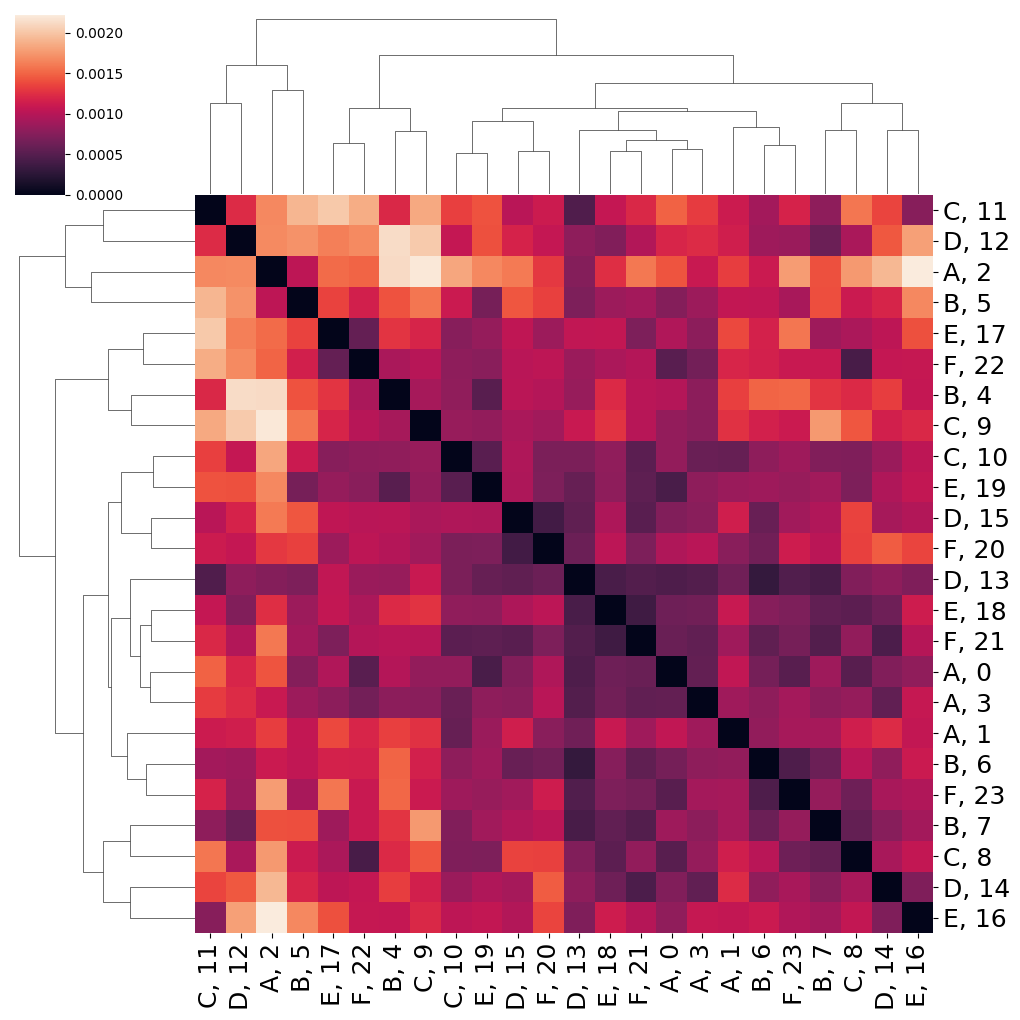

In [21]:
xdata_pearson = pairwise_distances(pearson_results_groups_final[1], metric='cosine')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(xdata_pearson,
                metric='euclidean',
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "pearson_constant_weight_increasing_noise.png")

#### Decreasing Weight and Constant Noise

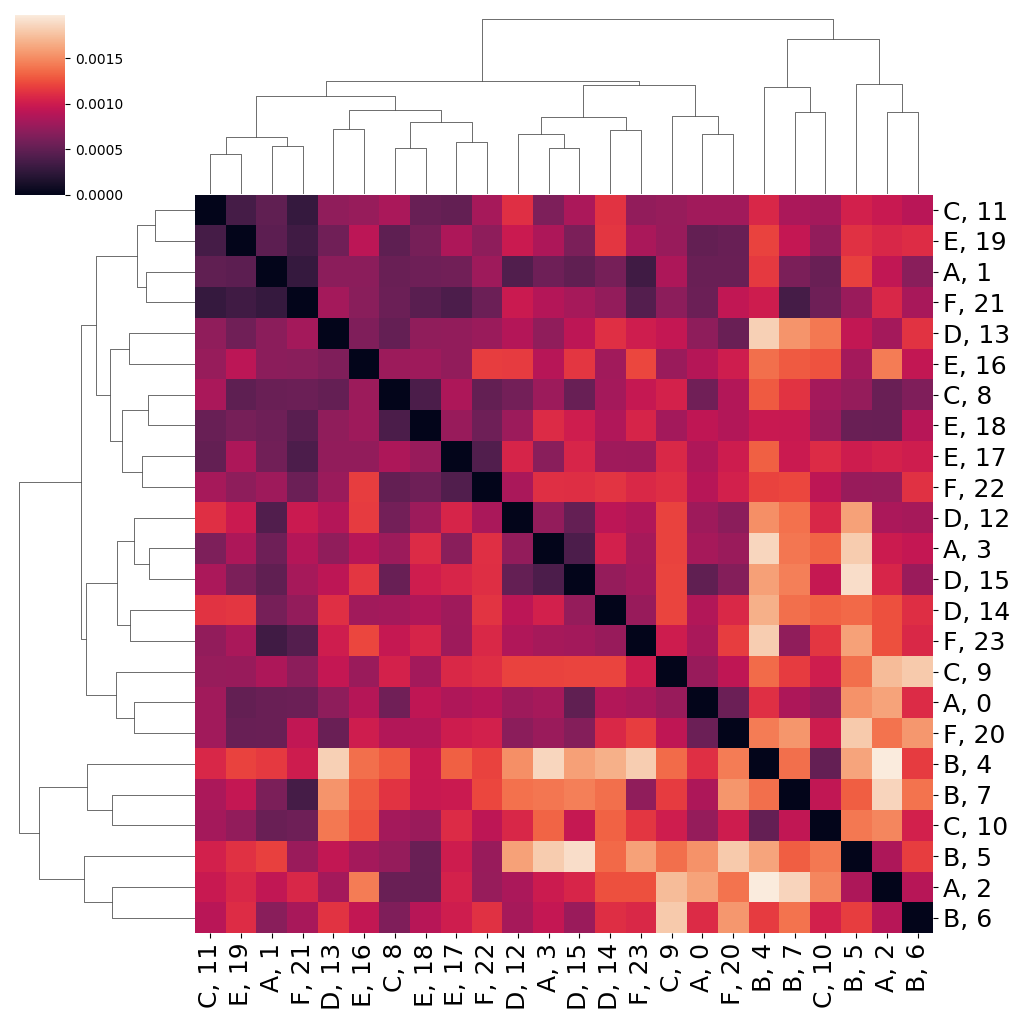

In [22]:
xdata_pearson = pairwise_distances(pearson_results_groups_final[2], metric='cosine')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(xdata_pearson,
                metric='euclidean',
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "pearson_decreasing_weight_constant_noise.png")

#### Decreasing Weight and Increasing Noise

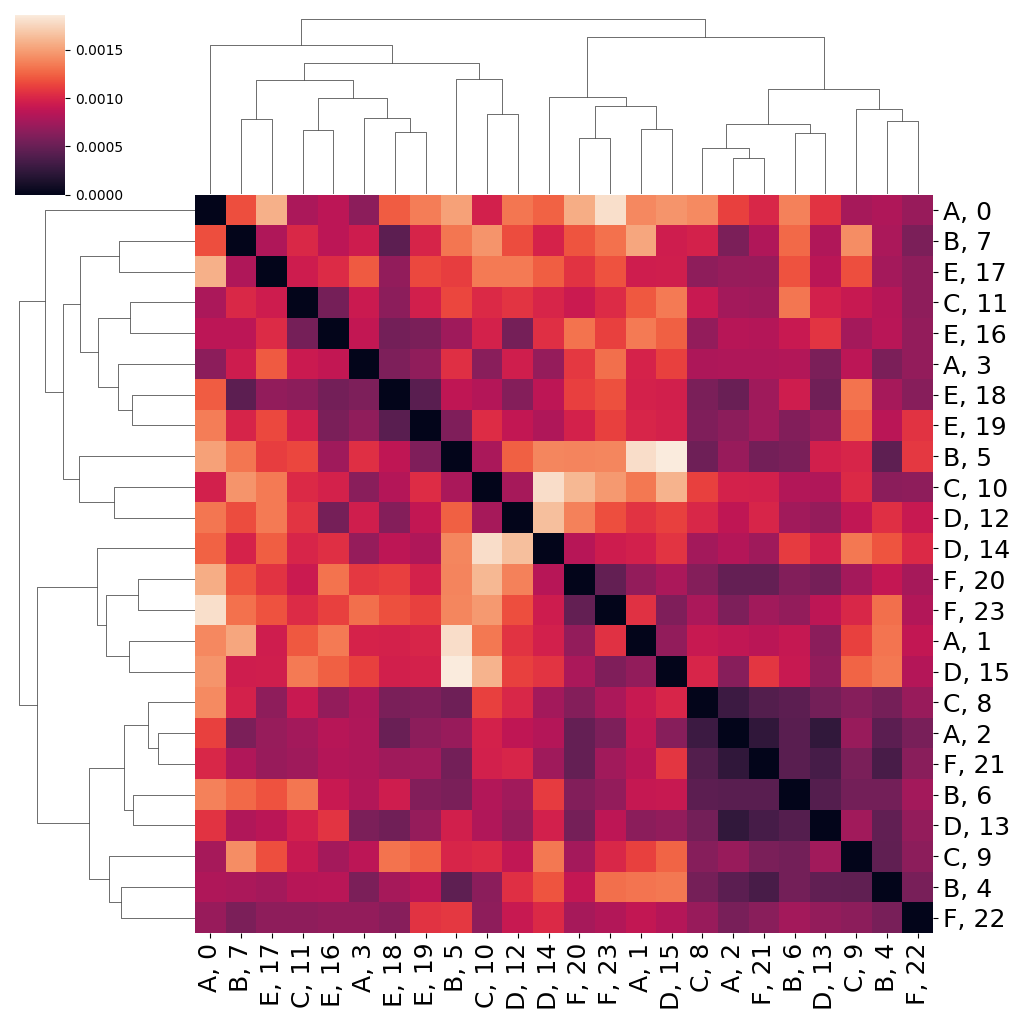

In [23]:
xdata_pearson = pairwise_distances(pearson_results_groups_final[3], metric='cosine')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(xdata_pearson,
                metric='euclidean',
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "pearson_decreasing_weight_increasing_noise.png")

# Euclidean Distance Clustering

In [24]:
def get_euclidean_distance_matrix(causal_timeseries, effect_timeseries):
    euc_results = []
    for c in causal_timeseries:
        one_row_result = []
        for e in effect_timeseries:
            temp_dist = math.dist(c, e)
            one_row_result.append(temp_dist)
        euc_results.append(one_row_result)

    return np.array(euc_results)

In [25]:
euclidean_results_groups_final = []
for ets in effect_timeseries_groups_final:
    euclidean_results = get_euclidean_distance_matrix(causal_timeseries, ets)
    euclidean_results_groups_final.append(euclidean_results)
    # break

#### Just A

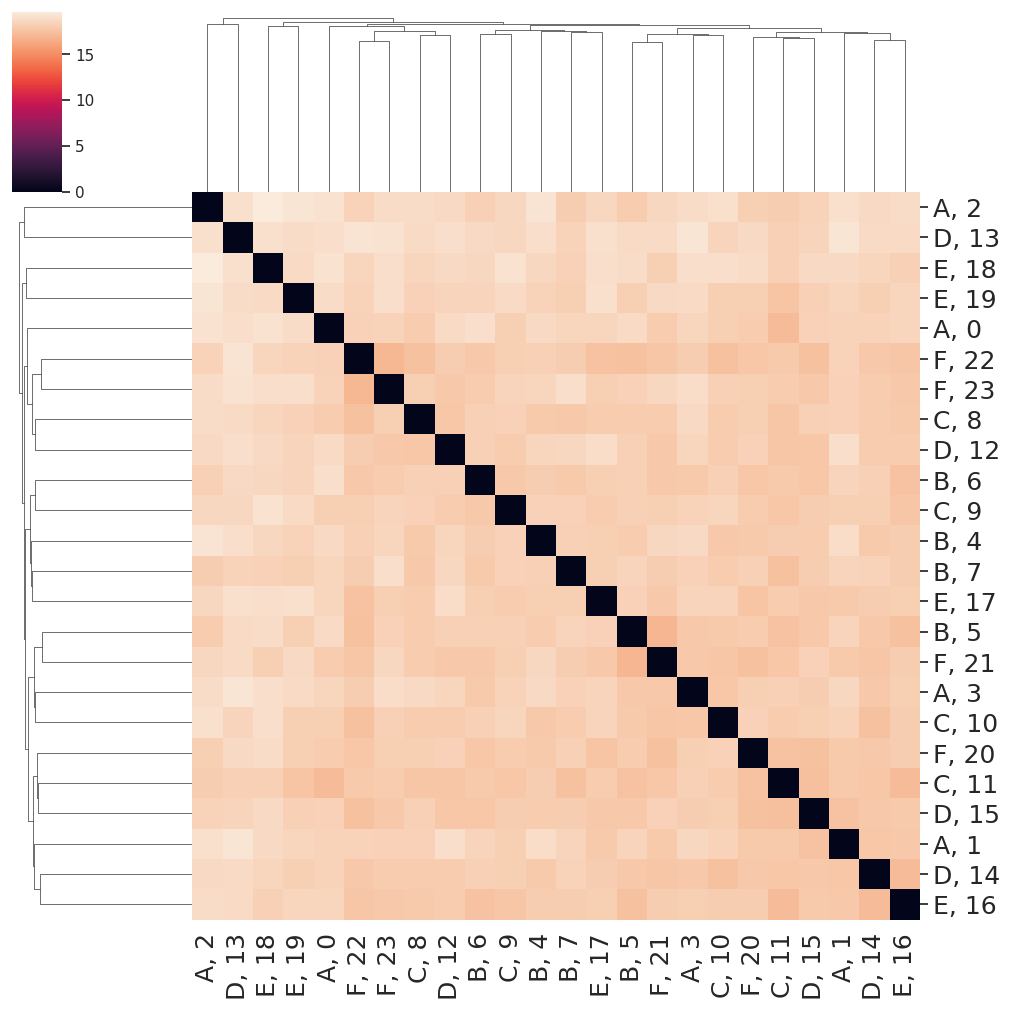

In [26]:
euc_results_just_A = get_euclidean_distance_matrix(causal_timeseries, causal_timeseries)
# Compute the linkage matrix for clustering
linkage_matrix = linkage(euc_results_just_A, method='complete')


# Create a clustermap using the DTW distance matrix
sns.set(font_scale=1)
raw_clustermap = sns.clustermap(euc_results_just_A,
                                row_linkage=linkage_matrix,
                                col_linkage=linkage_matrix,
                                col_cluster=True,
                                cmap='rocket',
                                figsize=(10,10),
                                yticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)],
                                xticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)])
raw_clustermap.ax_heatmap.tick_params(labelsize=18)
plt.setp(raw_clustermap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
raw_clustermap.savefig(base_dir + "euclidean_clustering_on_just_causal_ts.png")


#### Just B

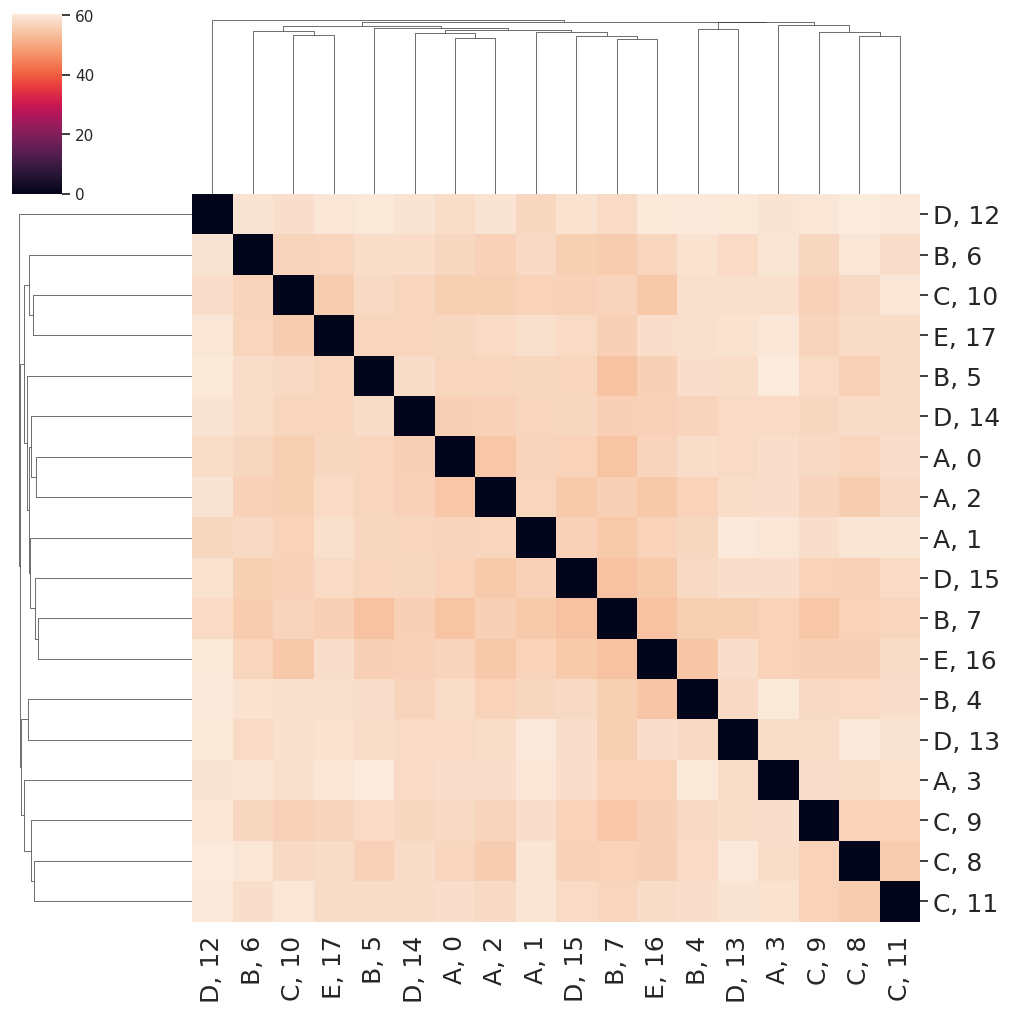

In [27]:
euc_results_just_B = get_euclidean_distance_matrix(effect_timeseries_groups_final[0], effect_timeseries_groups_final[0])
# Compute the linkage matrix for clustering
linkage_matrix = linkage(euc_results_just_B, method='complete')


# Create a clustermap using the DTW distance matrix
sns.set(font_scale=1)
raw_clustermap = sns.clustermap(euc_results_just_B,
                                row_linkage=linkage_matrix,
                                col_linkage=linkage_matrix,
                                col_cluster=True,
                                cmap='rocket',
                                figsize=(10,10),
                                yticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)],
                                xticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)])
raw_clustermap.ax_heatmap.tick_params(labelsize=18)
plt.setp(raw_clustermap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
raw_clustermap.savefig(base_dir + "euclidean_clustering_on_just_effect_ts.png")


#### Constant Weight Constant Noise

[1 2 6 3 2 3 3 2 1 2 2 2 2 5 2 2 1 4 3 2 2 3 2 4]
Adjusted Rand Index: -0.03016453382084095
Normalized Mutual Information: 0.29206242819600187


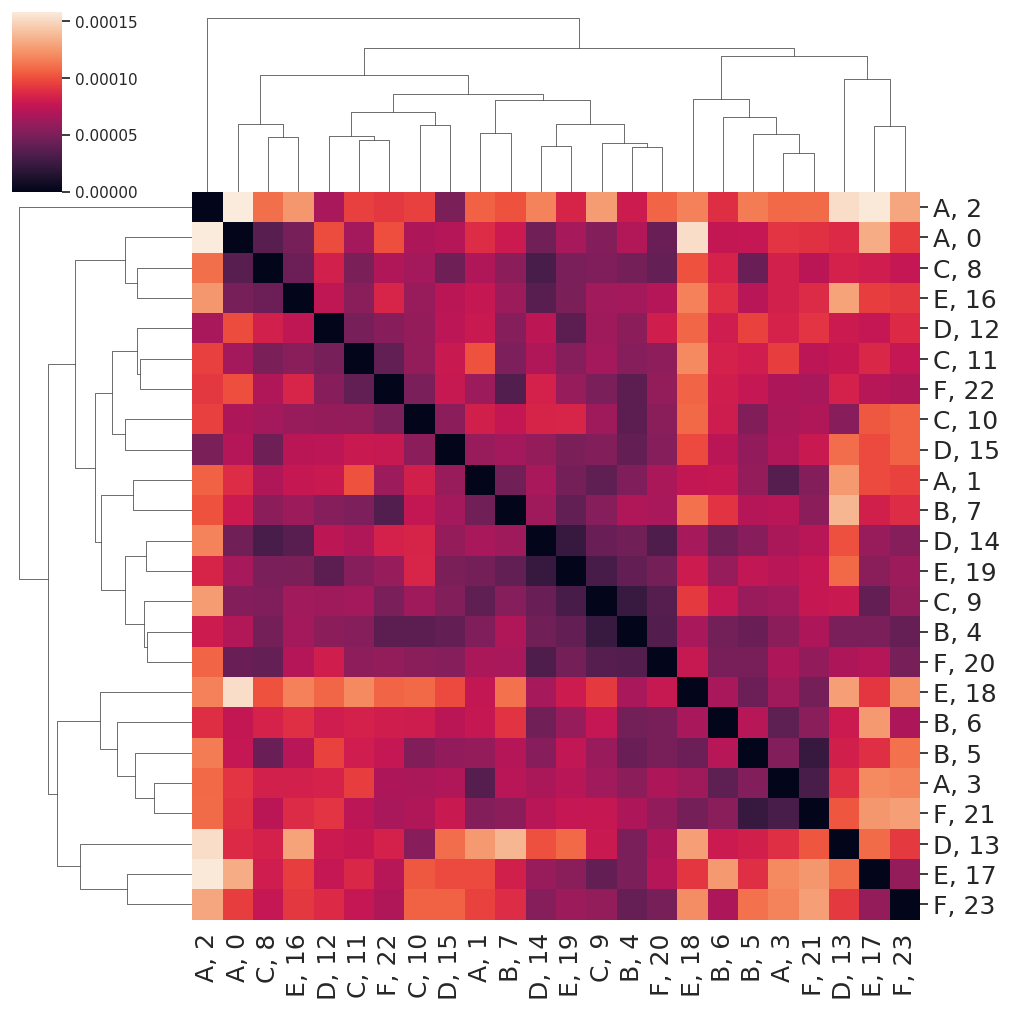

In [28]:
euc_pairwise_Data = pairwise_distances(euclidean_results_groups_final[0], metric='cosine')
linkage_matrix = linkage(euc_pairwise_Data, method='complete')

from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(euc_pairwise_Data,
                 row_linkage=linkage_matrix,
                       col_linkage=linkage_matrix,
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "euclidean_constant_weight_constant_noise.png")

true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

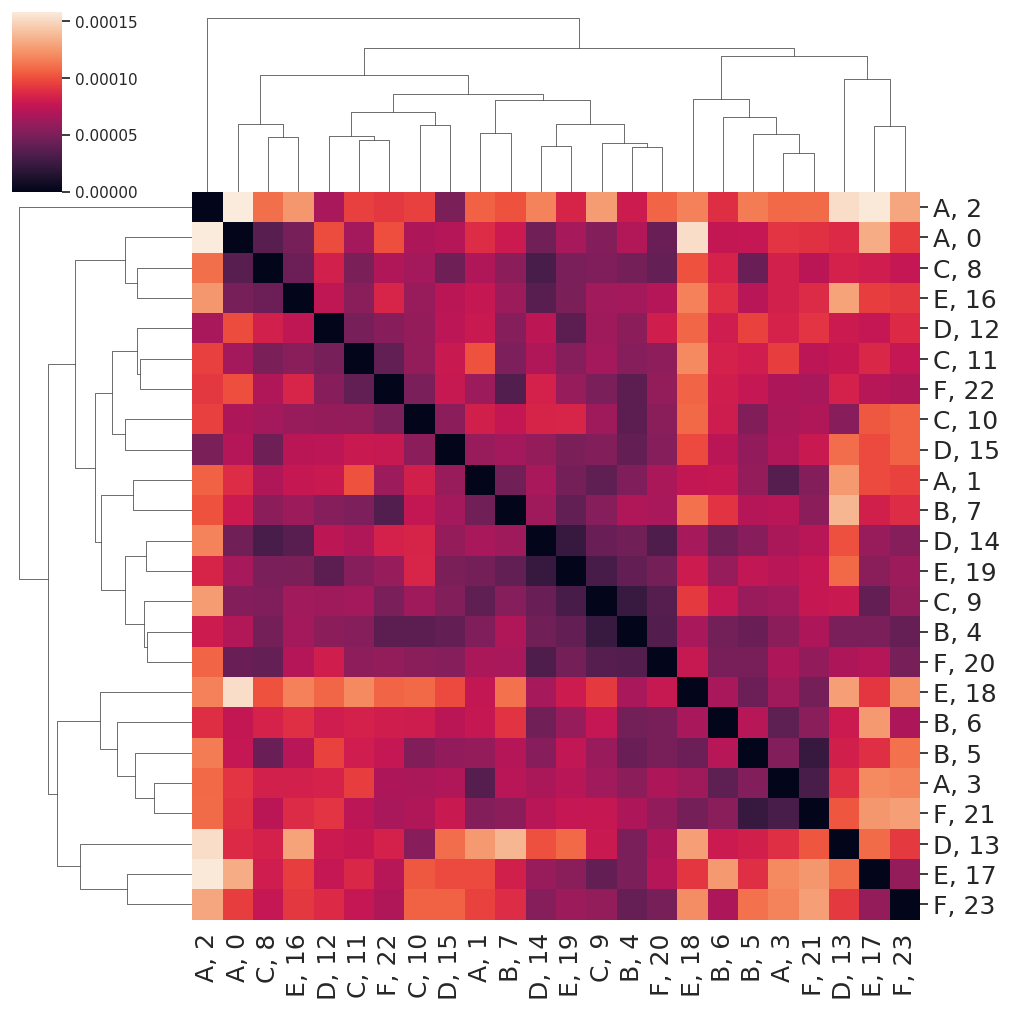

In [29]:
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage

# Assume causal_timeseries and effect_timeseries_groups_final are defined and have the correct shape

def get_euclidean_distance_matrix(causal_timeseries, effect_timeseries):
    euc_results = []
    for c in causal_timeseries:
        one_row_result = []
        for e in effect_timeseries:
            temp_dist = math.dist(c, e)
            one_row_result.append(temp_dist)
        euc_results.append(one_row_result)

    return np.array(euc_results)

# Only use the first group for demonstration
euclidean_results = get_euclidean_distance_matrix(causal_timeseries, effect_timeseries_groups_final[0])
euc_pairwise_Data = pairwise_distances(euclidean_results_groups_final[0], metric='cosine')

# Compute the linkage matrix for clustering
linkage_matrix = linkage(euc_pairwise_Data, method='complete')

# Use the original Euclidean results matrix with clustermap
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(euc_pairwise_Data,
                       row_linkage=linkage_matrix,
                       col_linkage=linkage_matrix,
                       cmap='rocket',
                       figsize=(10,10),
                       xticklabels=cause_labels,
                       yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18)  # Increase tick label font size
cgrid.savefig(base_dir + "euclidean_constant_weight_constant_noise.png")


# Cosine Distance Clustering

In [30]:
from sklearn.metrics.pairwise import cosine_distances
from numpy.linalg import norm

In [31]:
def get_cosine_distance_matrix(causal_timeseries, effect_timeseries):
    cosine_results = []
    for c in causal_timeseries:
        one_row_result = []
        for e in effect_timeseries:
            temp_dist = 1- np.dot(c,e)/(norm(c)*norm(e))
            one_row_result.append(temp_dist)
        cosine_results.append(one_row_result)

    return np.array(cosine_results)

In [32]:
cosine_results_groups_final = []
for ets in effect_timeseries_groups_final:
    cosine_results = get_cosine_distance_matrix(causal_timeseries, ets)
    cosine_results_groups_final.append(cosine_results)
    # break

#### Just A

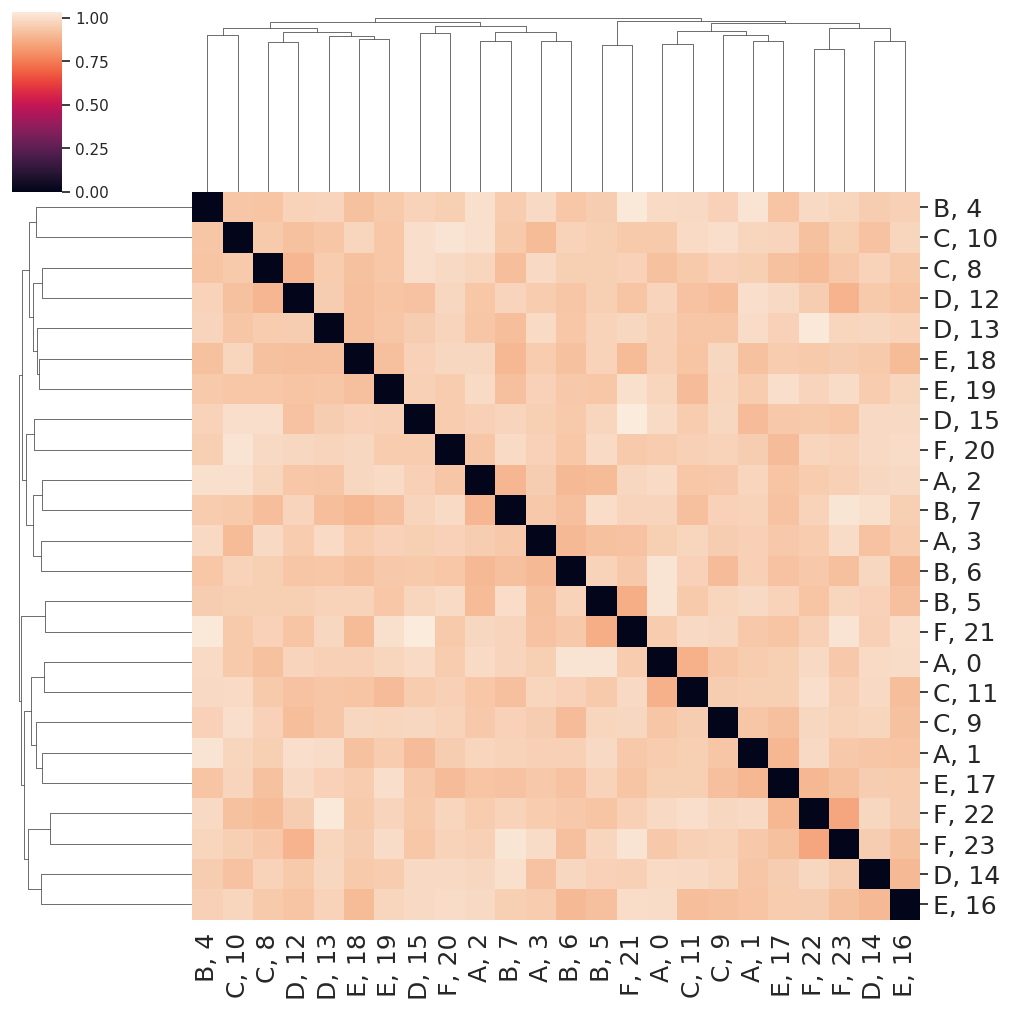

In [33]:
cosine_results_just_A = get_cosine_distance_matrix(causal_timeseries, causal_timeseries)
# Compute the linkage matrix for clustering
linkage_matrix = linkage(cosine_results_just_A, method='complete')


# Create a clustermap using the DTW distance matrix
sns.set(font_scale=1)
raw_clustermap = sns.clustermap(cosine_results_just_A,
                                row_linkage=linkage_matrix,
                                col_linkage=linkage_matrix,
                                col_cluster=True,
                                cmap='rocket',
                                figsize=(10,10),
                                yticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)],
                                xticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)])
raw_clustermap.ax_heatmap.tick_params(labelsize=18)
plt.setp(raw_clustermap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
raw_clustermap.savefig(base_dir + "cosine_clustering_on_just_causal_ts.png")


#### Constant Weight Constant Noise

[2 3 6 1 3 1 3 3 2 3 5 3 3 5 3 3 2 4 1 3 3 1 3 4]
Adjusted Rand Index: -0.04398689751988769
Normalized Mutual Information: 0.2809244704953605


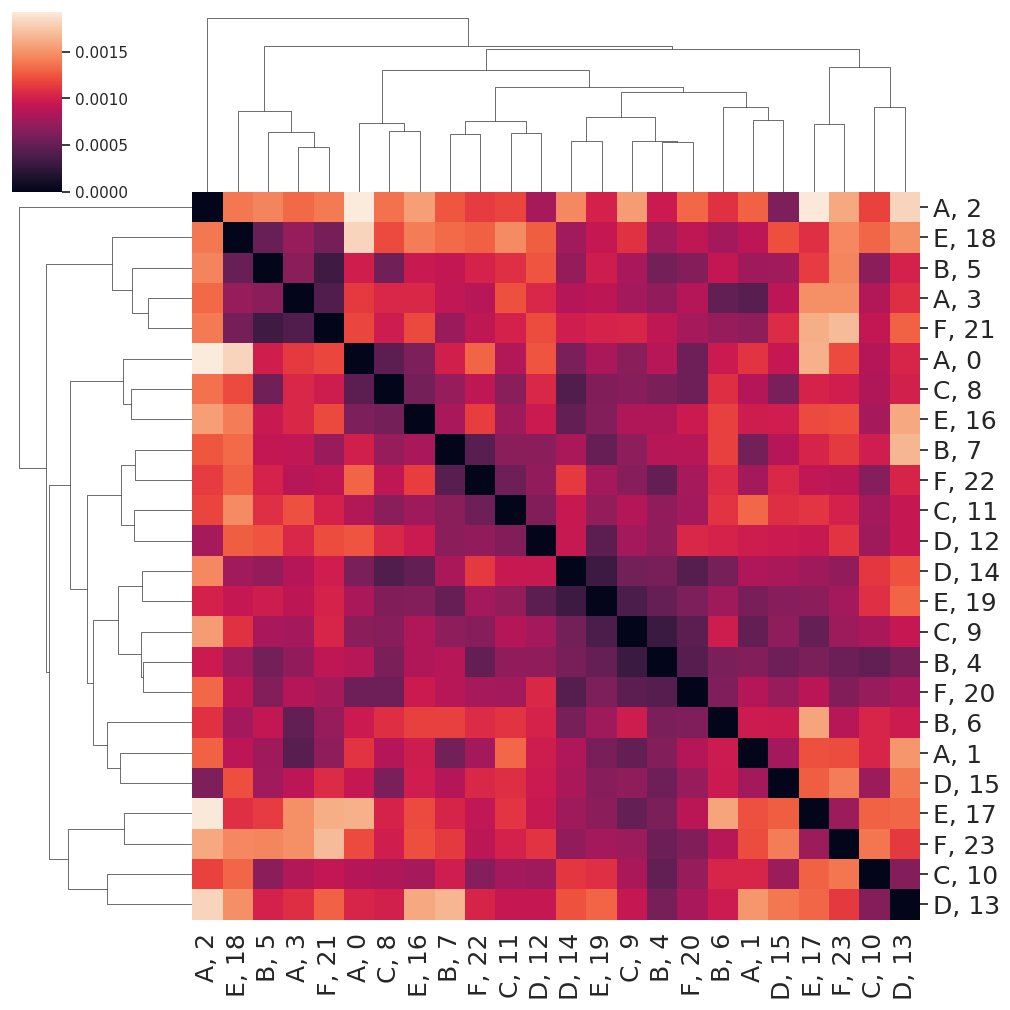

In [34]:
cos_pairwise_Data = pairwise_distances(cosine_results_groups_final[0], metric='cosine')
linkage_matrix = linkage(cos_pairwise_Data, method='complete')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(cos_pairwise_Data,

                 row_linkage=linkage_matrix,
                       col_linkage=linkage_matrix,
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "cosine_constant_weight_constant_noise.png")

true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

#### Constant Weight Increasing Noise

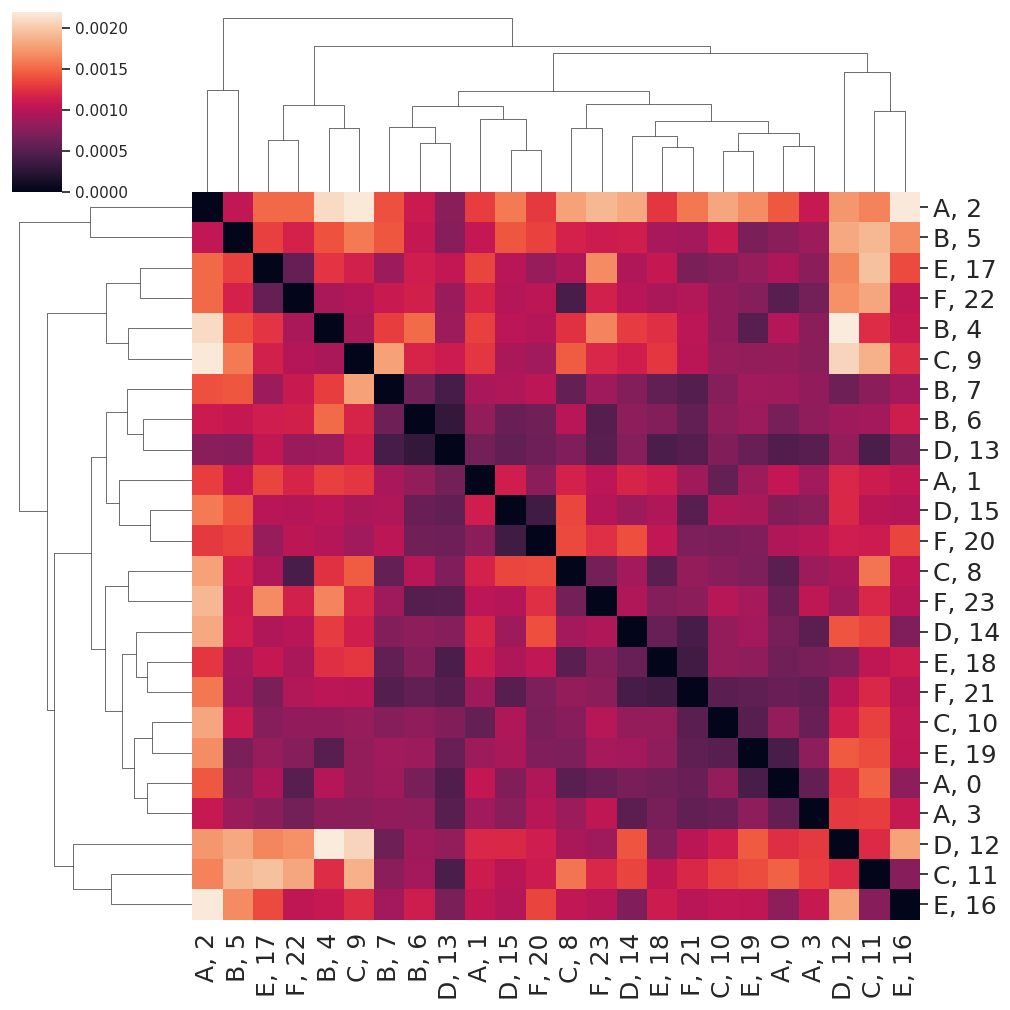

In [35]:
cos_pairwise_Data = pairwise_distances(cosine_results_groups_final[1], metric='cosine')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(cos_pairwise_Data,
                metric='euclidean',
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "cosine_constant_weight_increasing_noise.png")

#### Decreasing Weight Constant Noise

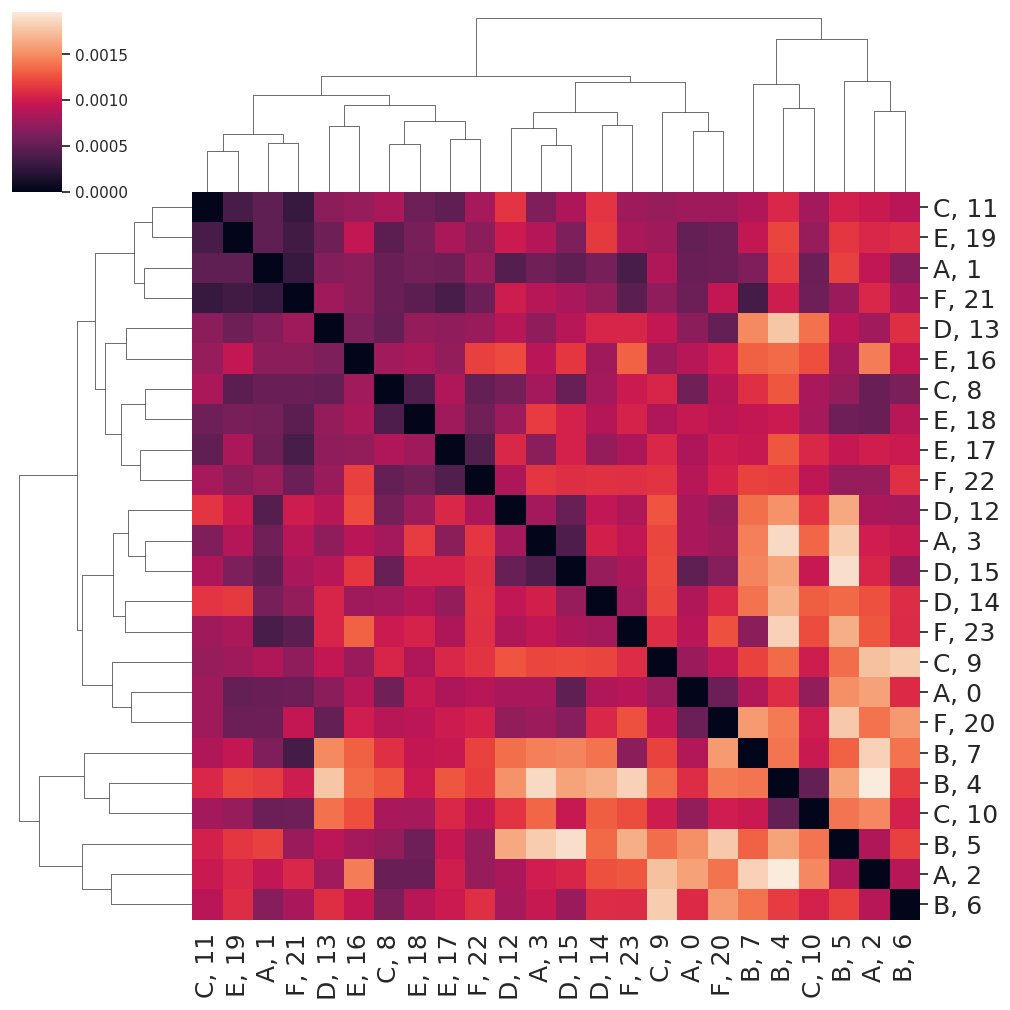

In [36]:
cos_pairwise_Data = pairwise_distances(cosine_results_groups_final[2], metric='cosine')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(cos_pairwise_Data,
                metric='euclidean',
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "cosine_decreasing_weight_constant_noise.png")

#### Decreasing Weight Increasing Noise

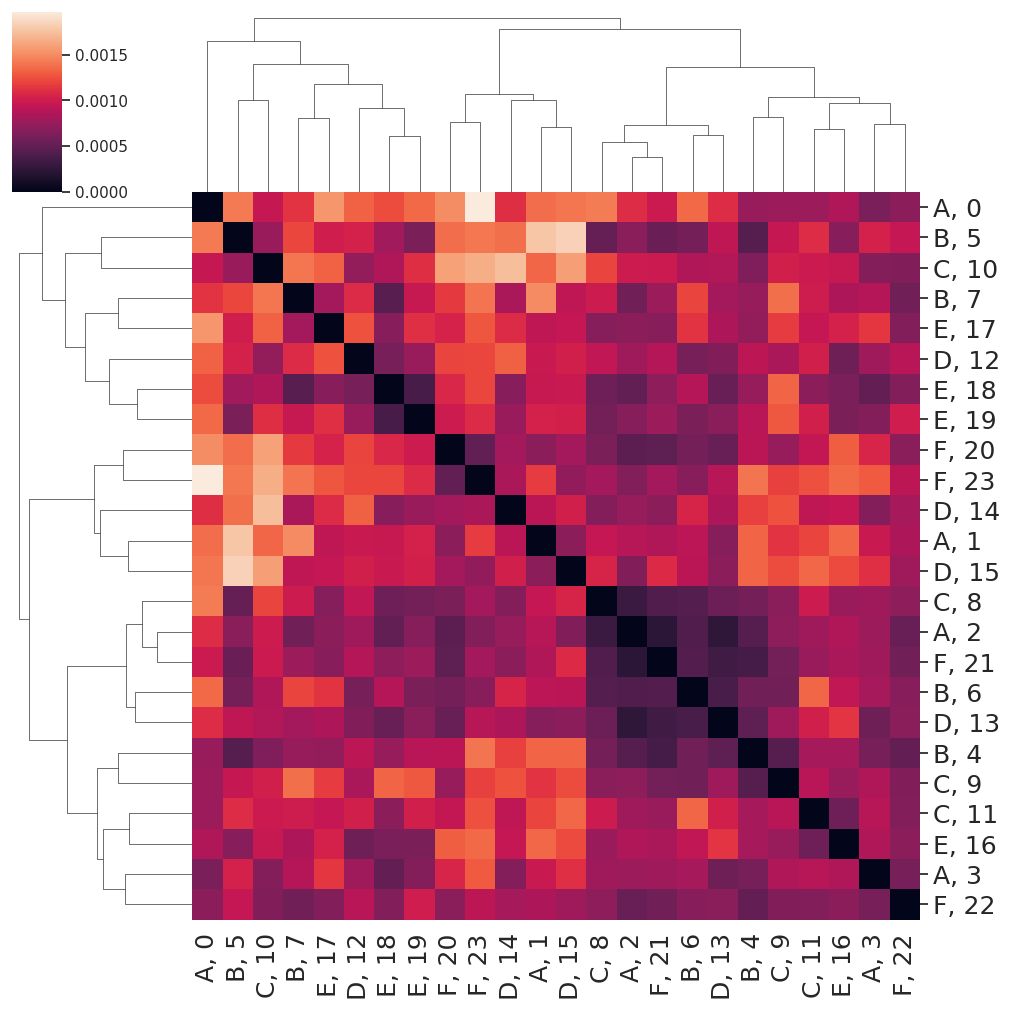

In [37]:
cos_pairwise_Data = pairwise_distances(cosine_results_groups_final[3], metric='cosine')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(cos_pairwise_Data,
                metric='euclidean',
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "cosine_decreasing_weight_increasing_noise.png")

# Clustering just the Alphas

In [38]:
from IPython.display import clear_output

# Clear the output buffer
clear_output(wait=True)

#### Euclidean

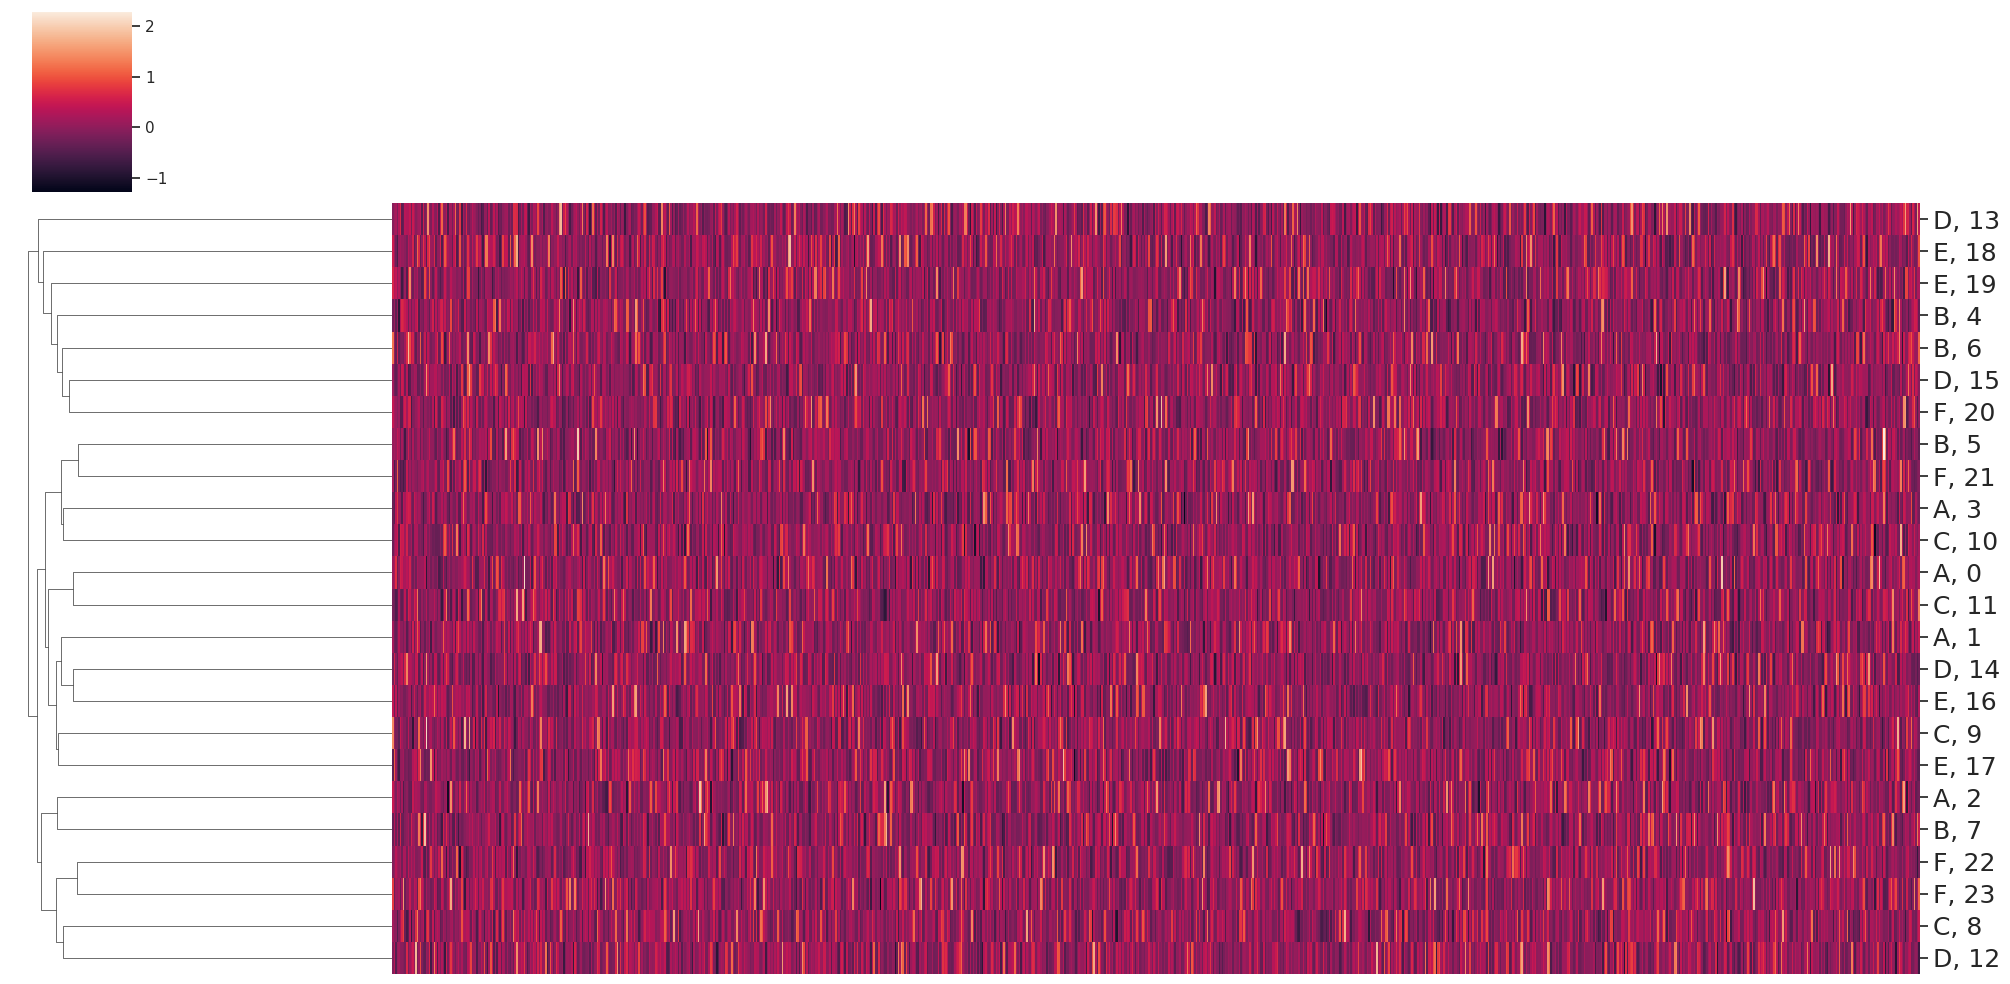

In [39]:
sns.set(font_scale = 1)
raw_clustermap = sns.clustermap(causal_timeseries,
                metric='euclidean',
                method='complete',
                col_cluster=False,
                cmap='rocket',
                figsize=(20,10),
                yticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)],
                xticklabels=[])
# raw_clustermap.fig.suptitle("Euclidean Clustering", size=25)
raw_clustermap.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
a = plt.setp(raw_clustermap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
raw_clustermap.savefig(base_dir + "euclidean_clustering_on_raw_causal_ts.png")

#### Cosine

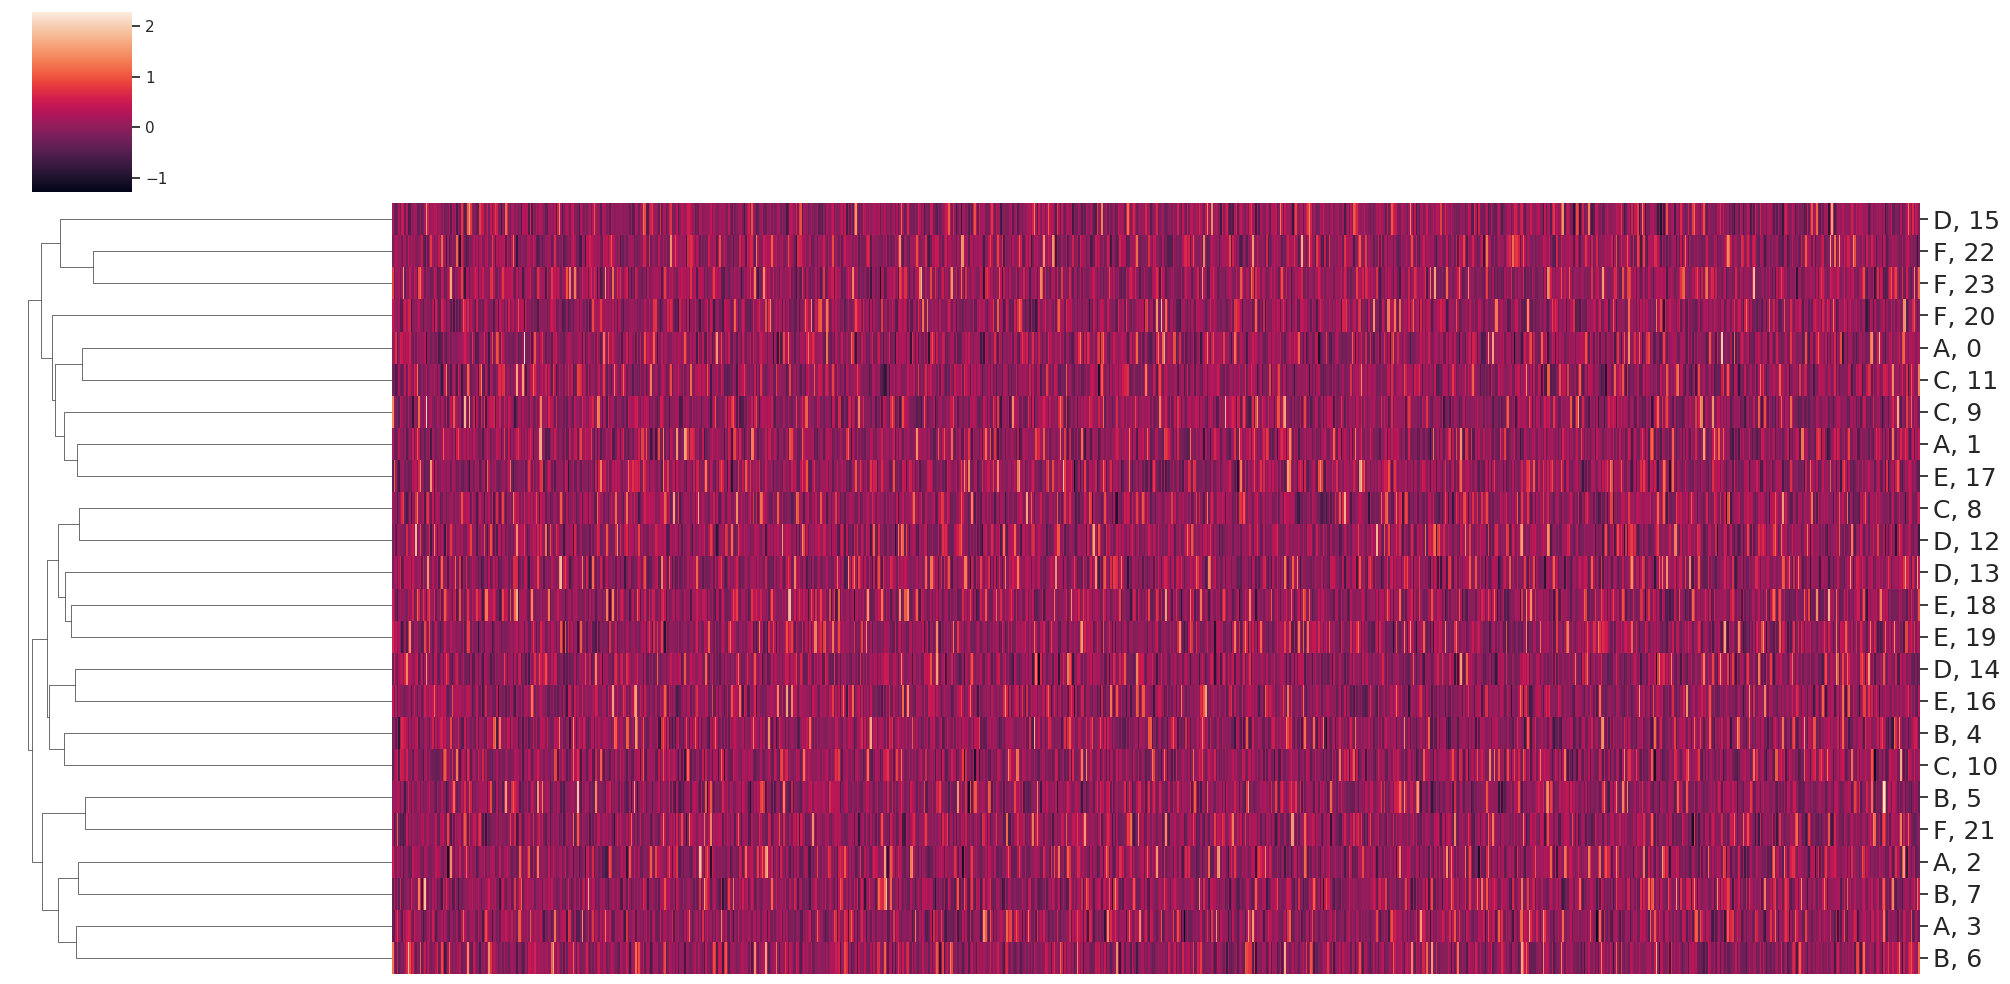

In [40]:
sns.set(font_scale = 1)
raw_clustermap = sns.clustermap(causal_timeseries,
                metric='cosine',
                method='complete',
                col_cluster=False,
                cmap='rocket',
                figsize=(20,10),
                yticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)],
                xticklabels=[])
# raw_clustermap.fig.suptitle("Euclidean Clustering", size=25)
raw_clustermap.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
a = plt.setp(raw_clustermap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
raw_clustermap.savefig(base_dir + "cosine_clustering_on_raw_causal_ts.png")

# Dynamic Time Warping

#### Just A

In [41]:
! pip install dtaidistance

In [42]:
causal_timeseries.shape[0]

24

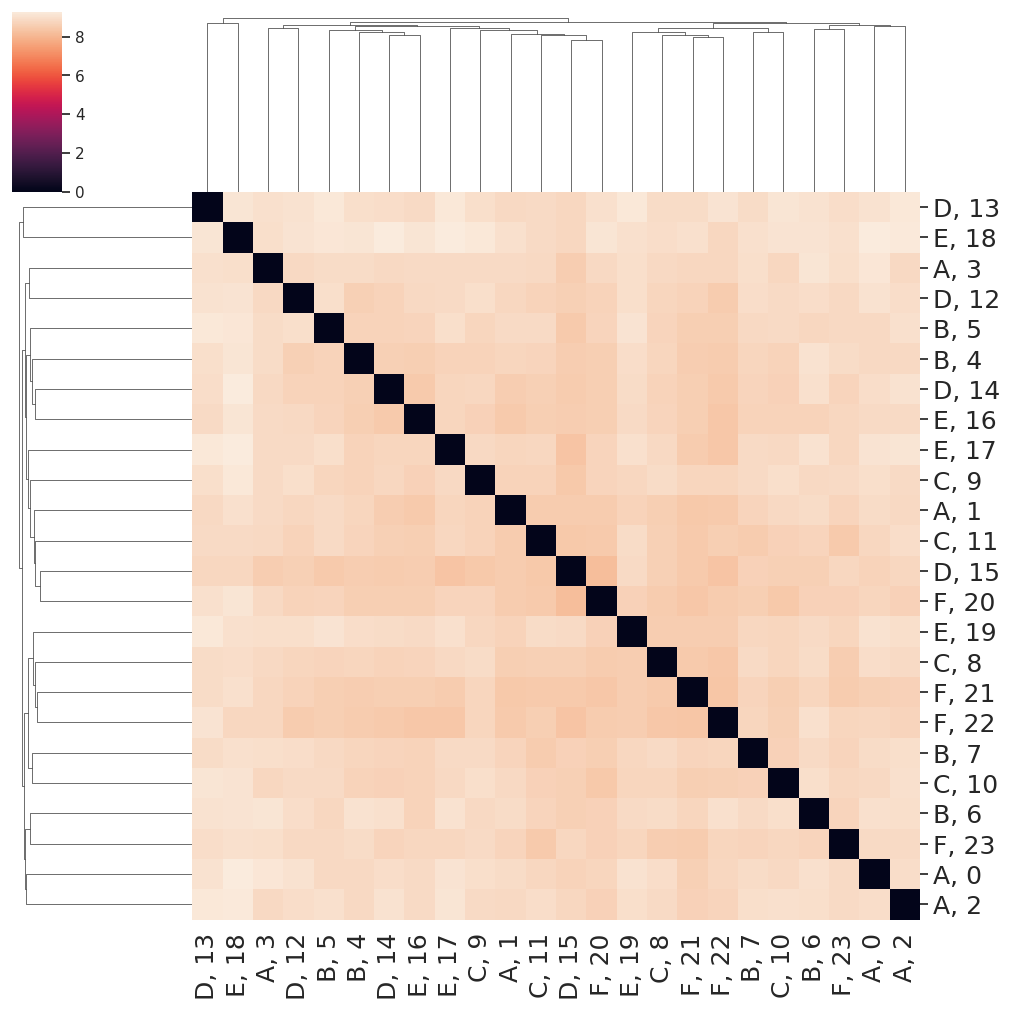

In [43]:
# Assume causal_timeseries is your time series data with shape (num_series, time_length)
# Compute the pairwise DTW distance matrix
dtw_distances = np.zeros((causal_timeseries.shape[0], causal_timeseries.shape[0]))
for i in range(causal_timeseries.shape[0]):
    start = time.time()
    for j in range(i + 1, causal_timeseries.shape[0]):
        distance = dtw.distance_fast(causal_timeseries[i], causal_timeseries[j])
        dtw_distances[i, j] = distance
        dtw_distances[j, i] = distance  # because the matrix is symmetric

# Compute the linkage matrix for clustering
linkage_matrix = linkage(dtw_distances, method='complete')


# Create a clustermap using the DTW distance matrix
sns.set(font_scale=1)
raw_clustermap = sns.clustermap(dtw_distances,
                                row_linkage=linkage_matrix,
                                col_linkage=linkage_matrix,
                                col_cluster=True,
                                cmap='rocket',
                                figsize=(10,10),
                                yticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)],
                                xticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)])
raw_clustermap.ax_heatmap.tick_params(labelsize=18)
plt.setp(raw_clustermap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
raw_clustermap.savefig(base_dir + "dtw_clustering_on_just_causal_ts.png")


#### Just B

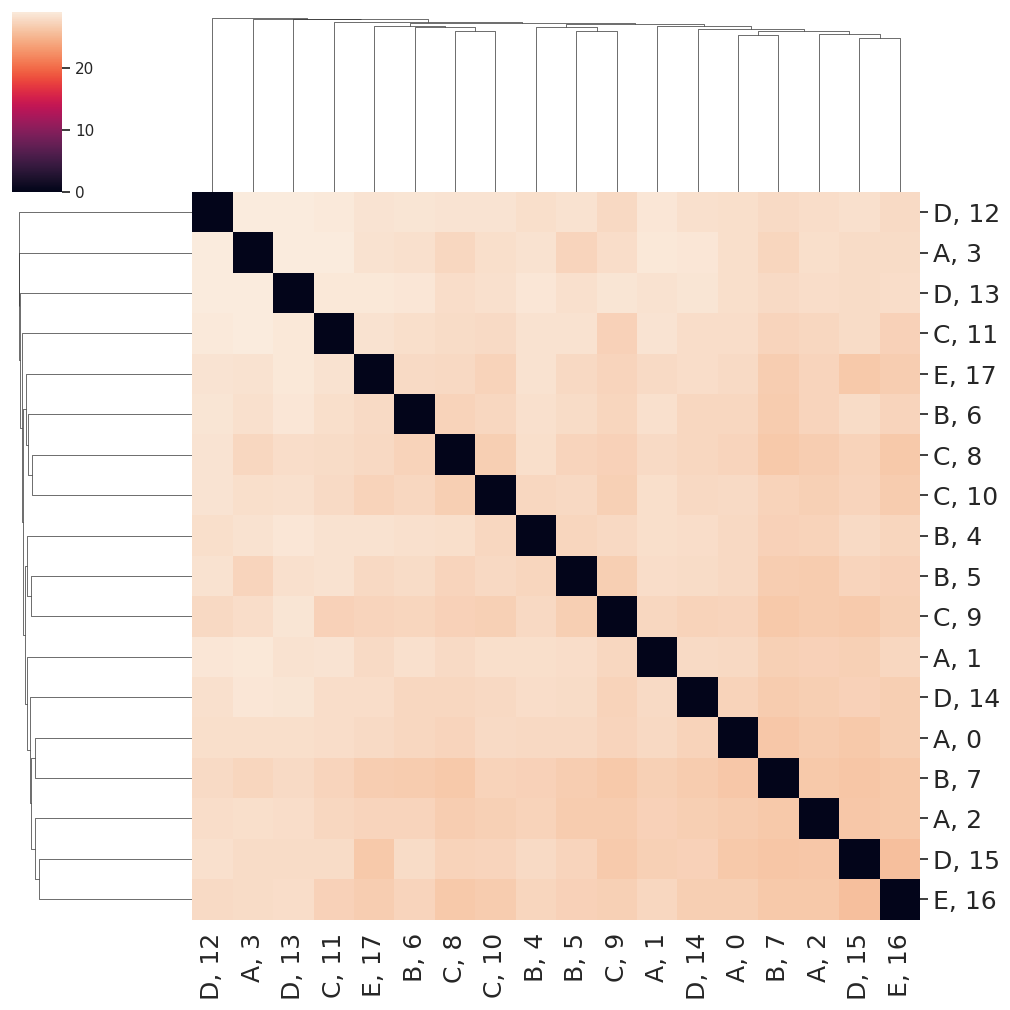

In [44]:
# Assume causal_timeseries is your time series data with shape (num_series, time_length)
# Compute the pairwise DTW distance matrix
dtw_distances = np.zeros((effect_timeseries_groups_final[0].shape[0], effect_timeseries_groups_final[0].shape[0]))
for i in range(effect_timeseries_groups_final[0].shape[0]):
    start = time.time()
    for j in range(i + 1, effect_timeseries_groups_final[0].shape[0]):
        distance = dtw.distance_fast(effect_timeseries_groups_final[0][i], effect_timeseries_groups_final[0][j])
        dtw_distances[i, j] = distance
        dtw_distances[j, i] = distance  # because the matrix is symmetric

# Compute the linkage matrix for clustering
linkage_matrix = linkage(dtw_distances, method='complete')


# Create a clustermap using the DTW distance matrix
sns.set(font_scale=1)
raw_clustermap = sns.clustermap(dtw_distances,
                                row_linkage=linkage_matrix,
                                col_linkage=linkage_matrix,
                                col_cluster=True,
                                cmap='rocket',
                                figsize=(10,10),
                                yticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)],
                                xticklabels=["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)])
raw_clustermap.ax_heatmap.tick_params(labelsize=18)
plt.setp(raw_clustermap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
raw_clustermap.savefig(base_dir + "dtw_clustering_on_just_effect_ts.png")


In [45]:
from dtaidistance import dtw
import time

def get_dtw_matrix(causal_timeseries, effect_timeseries):
    dtw_results = []
    counter = 0
    for c in causal_timeseries:
        one_row_result = []
        start = time.time()
        for e in effect_timeseries:
            distance = dtw.distance_fast(c, e)
            one_row_result.append(distance)
        counter += 1
        dtw_results.append(one_row_result)

    return np.array(dtw_results)

dtw_results_groups_final = []
for ets in effect_timeseries_groups_final:
    dtw_results = get_dtw_matrix(causal_timeseries, ets)
    dtw_results_groups_final.append(dtw_results)


#### Constant Weight Constant Noise

[1 1 2 3 1 6 1 1 1 4 2 1 3 1 3 2 1 2 1 5 2 2 2 1]
Adjusted Rand Index: -0.006448641179180101
Normalized Mutual Information: 0.311787165356167


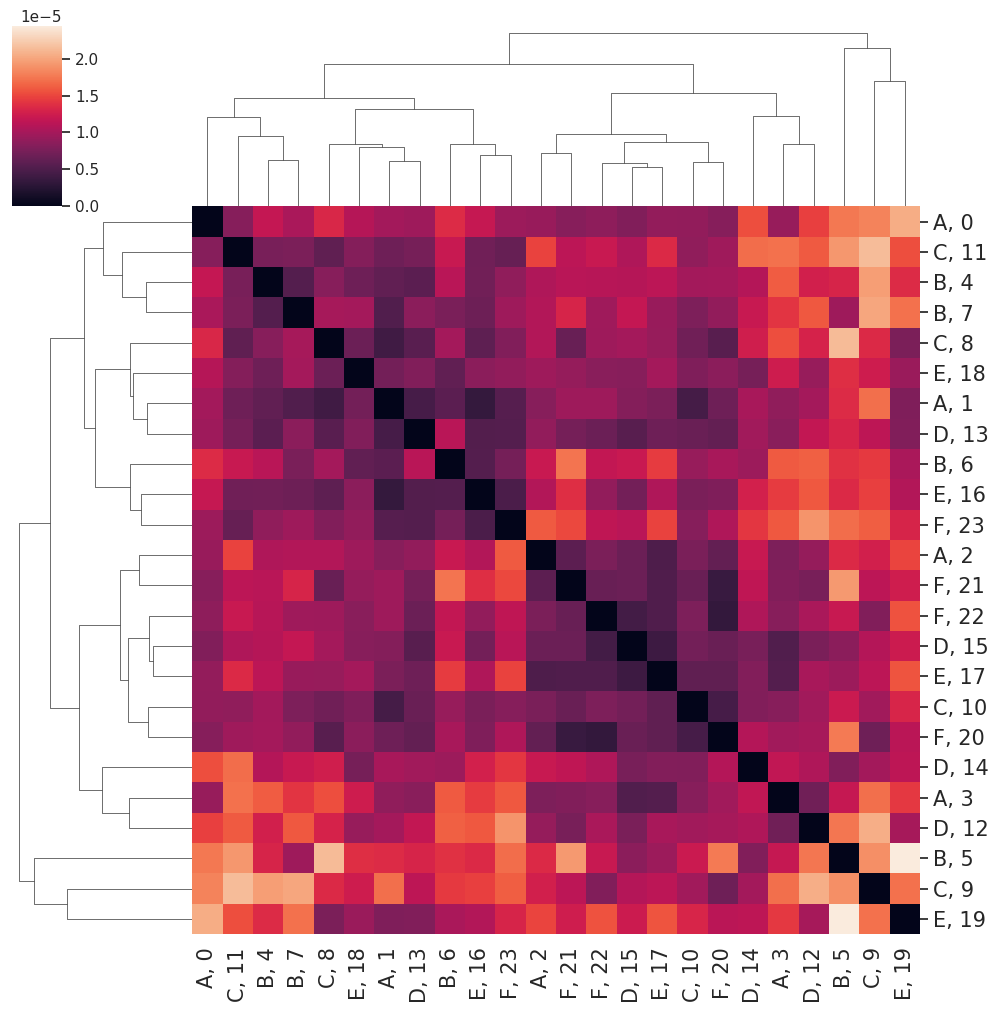

In [46]:
dtw_pairwise_Data = pairwise_distances(dtw_results_groups_final[0], metric='cosine')
linkage_matrix = linkage(dtw_pairwise_Data, method='complete')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(dtw_pairwise_Data,
                       row_linkage=linkage_matrix,
                       col_linkage=linkage_matrix,
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=15) # Increase tick label font size
cgrid.savefig(base_dir + "dtw_constant_weight_constant_noise.png")

true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

In [47]:
effect_timeseries_groups_final[0].shape

(18, 1000)

[1 1 2 3 1 6 1 1 1 4 2 1 3 1 3 2 1 2 1 5 2 2 2 1]


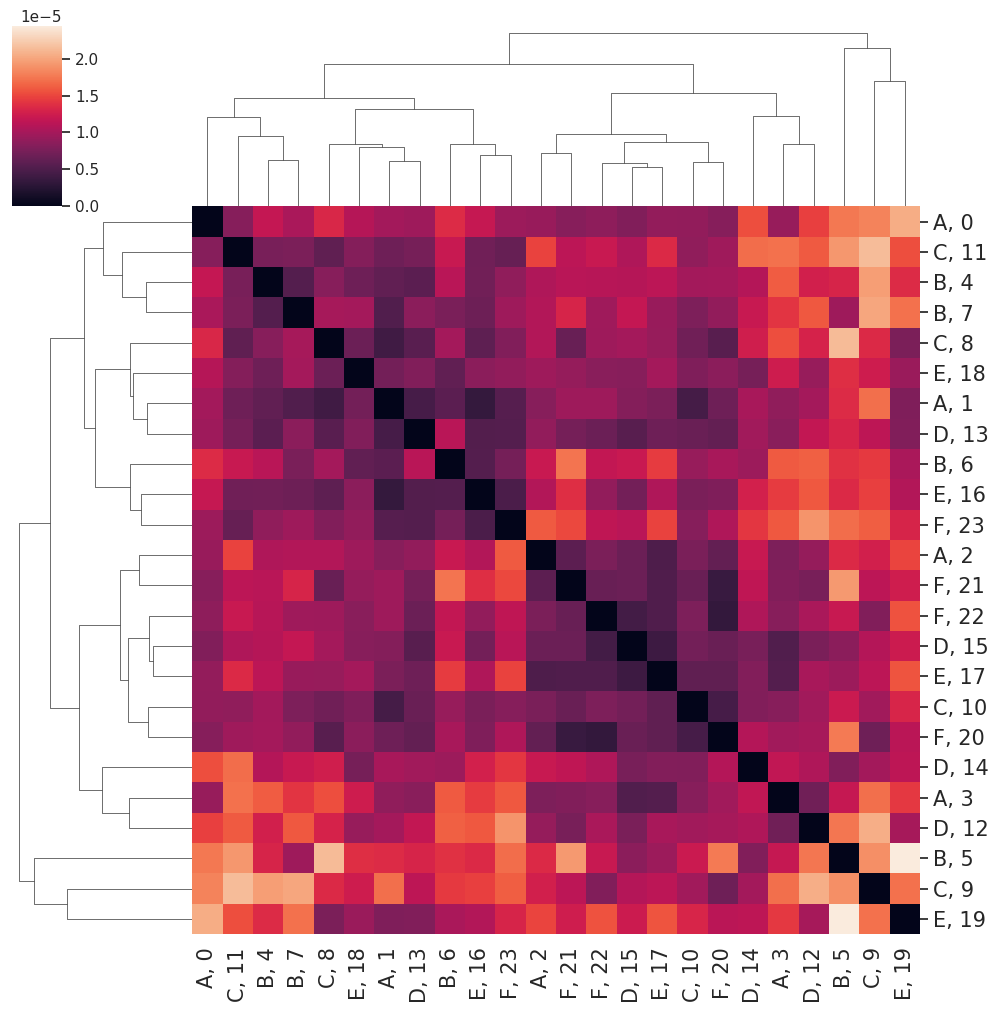

In [48]:
dtw_distances_to_test = np.zeros((causal_timeseries.shape[0], effect_timeseries_groups_final[0].shape[0]))
for i in range(causal_timeseries.shape[0]):
    start = time.time()
    for j in range(0, effect_timeseries_groups_final[0].shape[0]):
        distance = dtw.distance_fast(causal_timeseries[i], effect_timeseries_groups_final[0][j])
        dtw_distances_to_test[i, j] = distance
        # dtw_distances_to_test[j, i] = distance  # because the matrix is symmetric


dtw_pairwise_Data = pairwise_distances(dtw_distances_to_test, metric='cosine')
linkage_matrix = linkage(dtw_pairwise_Data, method='complete')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(dtw_pairwise_Data,
                 row_linkage=linkage_matrix,
                       col_linkage=linkage_matrix,
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=15) # Increase tick label font size
cgrid.savefig(base_dir + "dtw_constant_weight_constant_noise.png")

true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

[2 3 6 1 3 1 3 3 2 3 5 3 3 5 3 3 2 4 1 3 3 1 3 4]


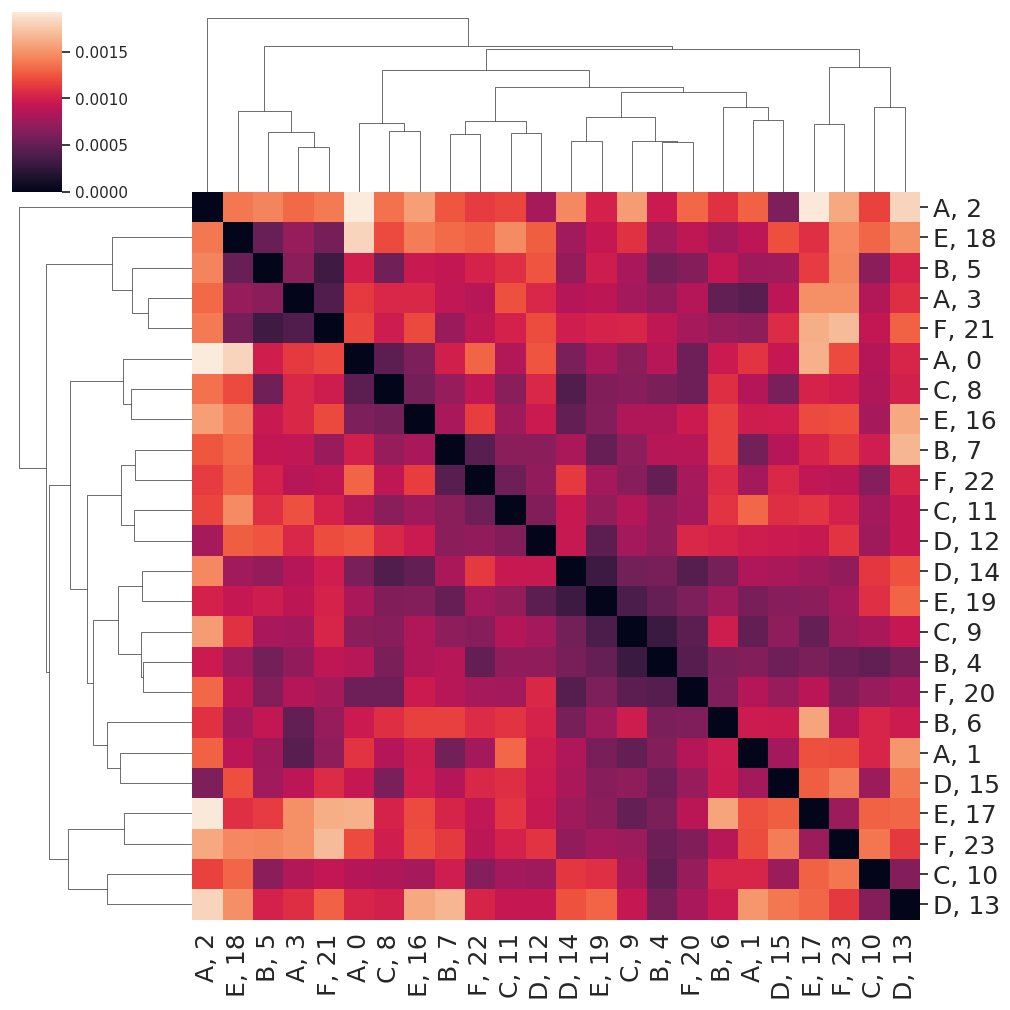

In [49]:
cos_pairwise_Data = pairwise_distances(cosine_results_groups_final[0], metric='cosine')
linkage_matrix = linkage(cos_pairwise_Data, method='complete')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(cos_pairwise_Data,

                 row_linkage=linkage_matrix,
                       col_linkage=linkage_matrix,
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.ax_heatmap.tick_params(labelsize=18) # Increase tick label font size
cgrid.savefig(base_dir + "cosine_constant_weight_constant_noise.png")

true_labels = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6]
cluster_labels = fcluster(linkage_matrix, 6, criterion='maxclust')
print(cluster_labels)

# Assuming you have true_labels as the ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

#### Constant Weight Increasing Noise

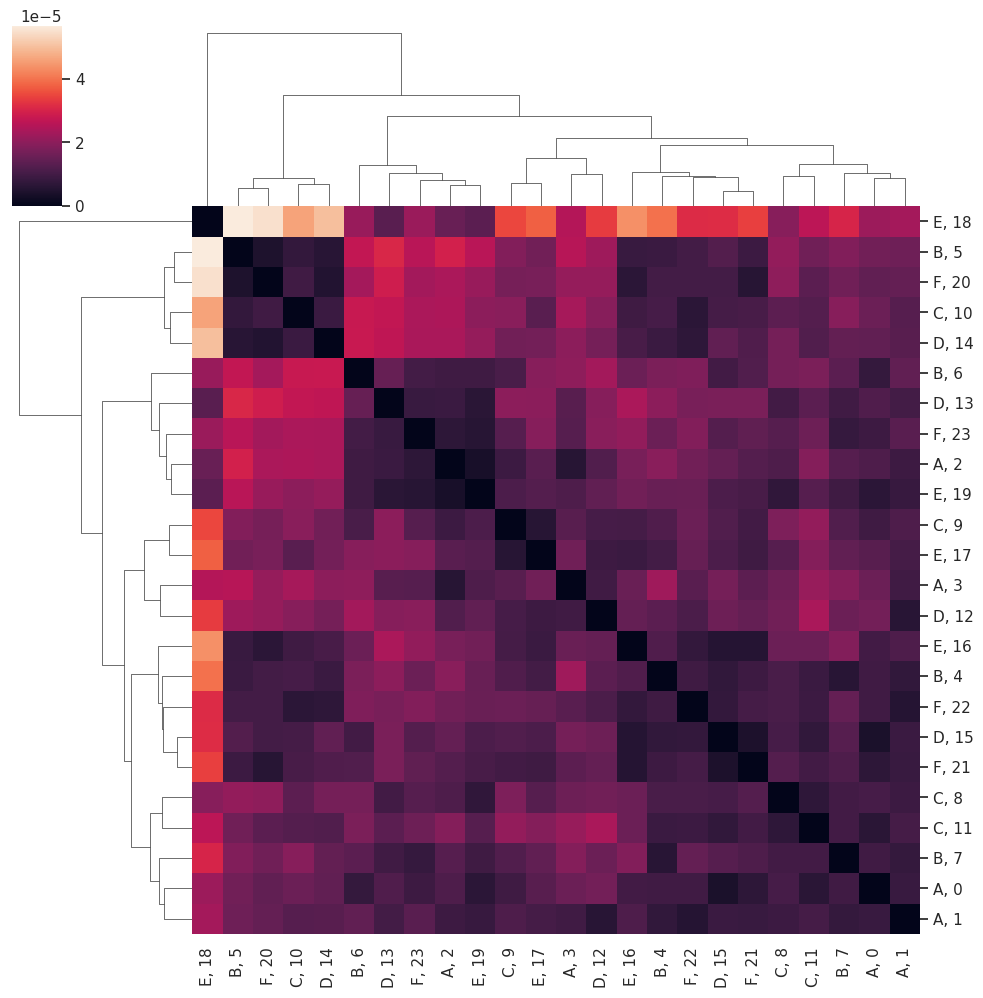

In [50]:
dtw_pairwise_Data = pairwise_distances(dtw_results_groups_final[1], metric='cosine')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(dtw_pairwise_Data,
                metric='euclidean',
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.savefig(base_dir + "dtw_constant_weight_increasing_noise.png")

#### Decreasing Weight Constant Noise

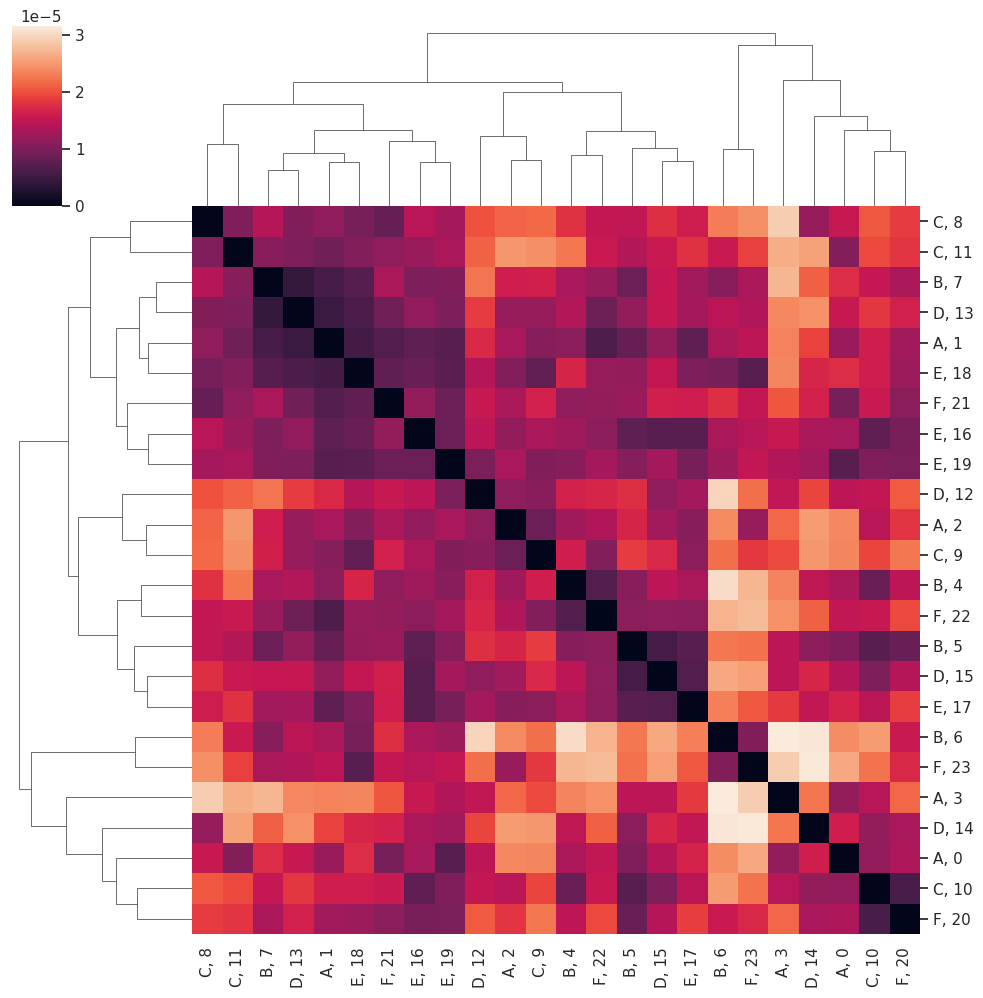

In [51]:
dtw_pairwise_Data = pairwise_distances(dtw_results_groups_final[2], metric='cosine')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(dtw_pairwise_Data,
                metric='euclidean',
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.savefig(base_dir + "dtw_decreasing_weight_constant_noise.png")

#### Decreasing Weight Increasing Noise

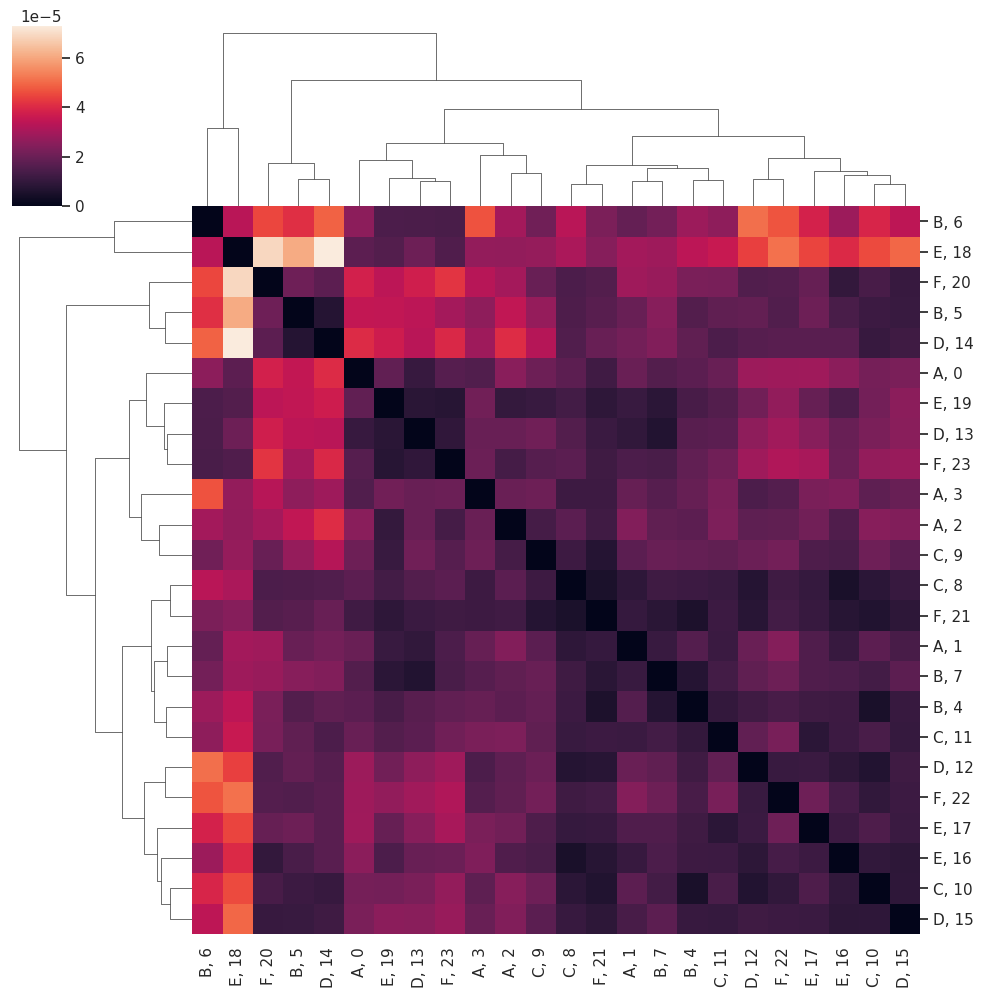

In [52]:
dtw_pairwise_Data = pairwise_distances(dtw_results_groups_final[3], metric='cosine')
from google.colab import files
cause_labels = ["{0}, {1}".format(chr(int(x/cluster_size)+65), x) for x in np.arange(0,num_clusters*cluster_size)]
cgrid = sns.clustermap(dtw_pairwise_Data,
                metric='euclidean',
                method='complete',
                cmap='rocket',
                figsize=(10,10),
                xticklabels=cause_labels,
                yticklabels=cause_labels)
cgrid.savefig(base_dir + "dtw_decreasing_weight_increasing_noise.png")